In [1]:
import pandas as pd
import numpy as np

raw = pd.read_csv('datasets/mushrooms_dataset.csv', na_values = "['-']", encoding = 'utf-8')
df = raw.copy()

df.head()

,chut,hymenofor,jedla,jmeno,klobouk_barva,klobouk_povrch,klobouk_tvar,konzistence,latin,pochva,prsten,tren_barva,tren_povrch,tren_tvar,vune,vyskyt_doba,vyskyt_misto
0,['příjemná'],['lupeny'],['jedlá'],Bedla červenající,['hnědá'],['šupinkatý'],"['kulovitý, plochý, s\xa0hrbolkem, zvoncovitý,...",['dřevnatá'],(Macrolepiota rhacodes),['nemá'],['má'],"['bílá, okrová']",['hladký'],"['válcovitý, hlízovitý']",['příjemná'],"['červenec, srpen, září, říjen']","['jehličnatý les, listnatý les, smíšený les, z..."
1,NaN,['rourky'],['nejedlá'],Anýzovník vonný,"['hnědá, žlutá']","['hrbolkatý, jamkatý, plstnatý']","['polokulovitý, excentrický']",['dřevnatá'],(Gloeophyllum odoratum),NaN,NaN,NaN,NaN,NaN,"['anýzová, aromatická']","['leden, únor, březen, duben, květen, červen, ...","['jehličnatý les, smíšený les']"
2,['příjemná'],['lupeny'],['jedlá'],Bedla vysoká,['hnědá'],['šupinkatý'],"['kulovitý, plochý, zvoncovitý']",['dřevnatá'],(Macrolepiota procera),['nemá'],['má'],['hnědá'],NaN,"['válcovitý, hlízovitý']","['příjemná, houbová']","['červenec, srpen, září, říjen']","['jehličnatý les, listnatý les, smíšený les, p..."
3,"['příjemná, kořenitá, sladká']",['jiné'],['jedlá'],Bělolanýž obecný,NaN,NaN,NaN,['tvrdá'],(Choiromyces meandriformis),NaN,NaN,NaN,NaN,NaN,"['kořenitá, aromatická']","['červenec, srpen, září']","['jehličnatý les, listnatý les, smíšený les']"
4,['hořká'],['rourky'],['nejedlá'],Březovník obecný,"['bílá, okrová']",['hladký'],['polokulovitý'],['měkká'],(Piptoporus betulinus),NaN,NaN,NaN,NaN,NaN,NaN,"['květen, červen, červenec, srpen, září, říjen']","['listnatý les, smíšený les, parky']"


# CLEAN DATA

In [2]:
# define function to get rid of ['']

def delist(value):
    if value is not np.nan:
        value = value[2:-2]
        return value
    else:
        return value

# clean columns of parentheses
df['latin'] = df['latin'].str.replace(r'[()]', '')

# define columns that are not surroundedby [''] and drop them
cols_name = ['jmeno', 'latin']
cols_start = df[cols_name]
df = df.drop(columns = cols_name)

#apply function to rest
df = df.applymap(delist)

# change binary to 0 or 1
df['pochva'] = df['pochva'].map({'má': 1, 'nemá': 0}).fillna(0)
df['prsten'] = df['prsten'].map({'má': 1, 'nemá': 0}).fillna(0)

# clean lupeny
df['hymenofor'] = df['hymenofor'].replace('jiné', 'nema')

In [3]:
# cols with values that need to be filled
cols_fill = ['klobouk_barva', 'klobouk_povrch', 'klobouk_tvar', 'konzistence', 'tren_barva', 
             'tren_povrch', 'tren_tvar', 'vune', 'hymenofor']

# loop through and fill NA with "does not have"
for column in df[cols_fill]:
    df[column] = df[column].fillna('nema')

In [4]:
# clean column
def clean_unicode(value):
    return value.replace('\\xa0', ' ')

df['klobouk_tvar'] = df[['klobouk_tvar']].applymap(clean_unicode)

In [5]:
# join dataframes again
df = df.merge(cols_start, right_index = True, left_index = True, how = 'outer')

# create column of species
df['rod'] = df['latin'].str.extract(r'(\w*)(?:\w*)')

# drop some cols
cols_to_drop = ['chut']
df.drop(columns = cols_to_drop, inplace = True)

# set index
df.set_index('jmeno', inplace = True)

In [6]:
# binarize edible column - jedla = 1, else 0

df['jedla'] = df['jedla'].where(df['jedla'] == 'jedlá', 0).replace('jedlá', 1)

# PLOT GENUS

In [7]:
threshold = 2

df_lowOccurences = df.copy()

value_counts = df_lowOccurences.stack().value_counts() # Entire DataFrame 
to_remove = value_counts[value_counts <= threshold].index
df_lowOccurences.replace(to_remove, np.nan, inplace = True)
df_lowOccurences.dropna(subset = ['rod'], inplace = True)

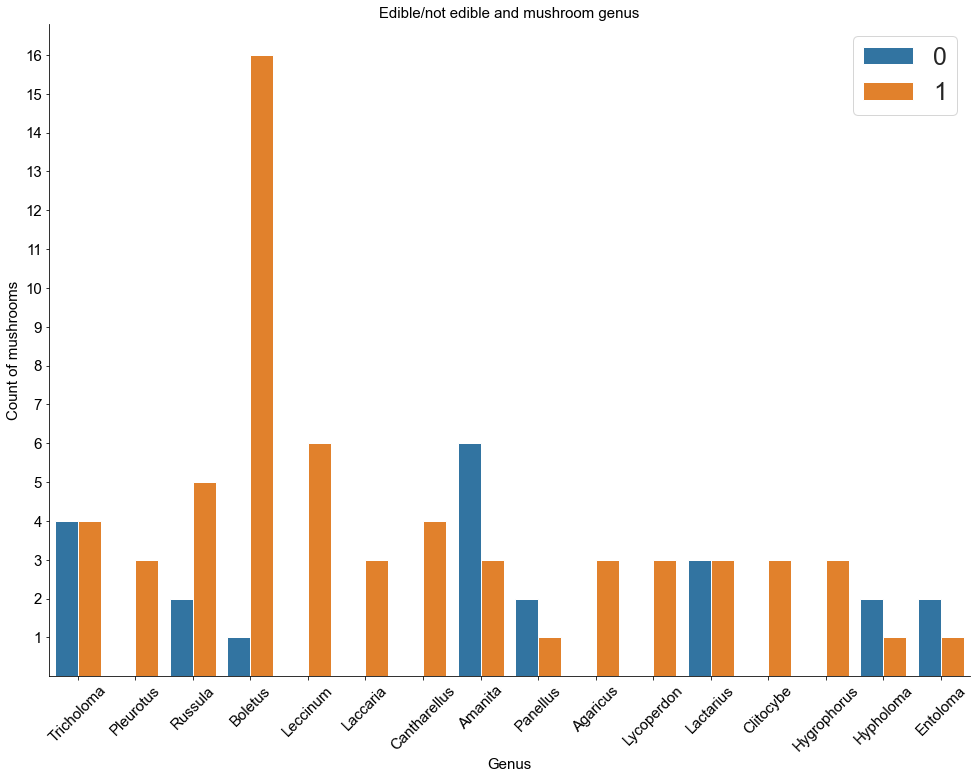

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

size = (16.5, 12)
fig, ax = plt.subplots(figsize=size)

sns.set_style('white')
sns.countplot(x="rod", hue="jedla", data=df_lowOccurences)
sns.despine()
plt.xticks(rotation= 45, fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_xlabel('Genus', fontsize = 15)
ax.set_ylabel('Count of mushrooms', fontsize = 15)
ax.set_title('Edible/not edible and mushroom genus', fontsize = 15)
plt.legend(prop={'size': 25})
ax.set_yticks(list(range(1,17)));

# PLOT HYMENOFOR

In [9]:
#define function
def get_first(value):
    value = value.split(',')[0]
    return value

#apply
df_hymenofor = df.copy()
df_hymenofor[cols_fill] = df_hymenofor[cols_fill].applymap(get_first)

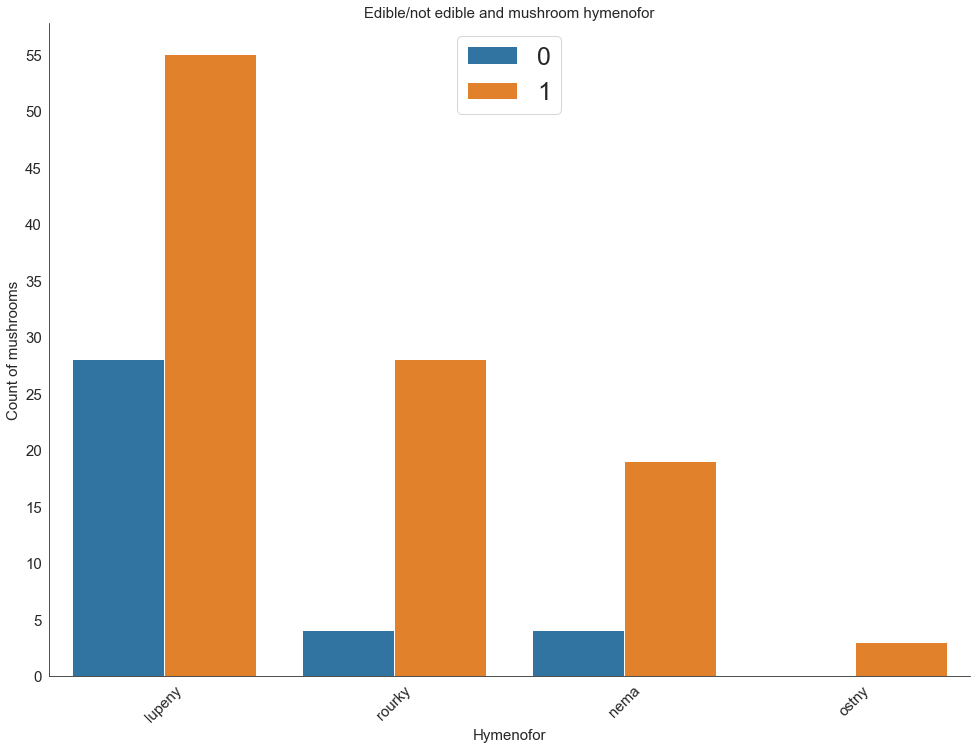

In [10]:
size = (16.5, 12)
fig, ax = plt.subplots(figsize=size)

sns.set_style('white')
sns.countplot(x="hymenofor", hue="jedla", data=df_hymenofor)
sns.despine()
plt.xticks(rotation= 45, fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_xlabel('Hymenofor', fontsize = 15)
ax.set_ylabel('Count of mushrooms', fontsize = 15)
ax.set_title('Edible/not edible and mushroom hymenofor', fontsize = 15)
plt.legend(prop={'size': 25})
ax.set_yticks(list(range(0,60, 5)));

# PLOT MONTH

In [11]:
def to_list(value):
    list_of_vals = value.split(', ')
    return list_of_vals

df['vyskyt_doba'] = df[['vyskyt_doba']].applymap(to_list)
df['vyskyt_misto'] = df[['vyskyt_misto']].applymap(to_list)

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

col_to_binarize1 = df['vyskyt_doba']
col_to_binarize2 = df['vyskyt_misto']

mlb = MultiLabelBinarizer()

df_months_binarized = pd.DataFrame(mlb.fit_transform(col_to_binarize1), columns = mlb.classes_, index = df.index)
df_places_binarized = pd.DataFrame(mlb.fit_transform(col_to_binarize2), columns = mlb.classes_, index = df.index)

In [13]:
# drop columns
df = df.drop(columns = ['vyskyt_doba', 'vyskyt_misto'])

# merge with binarized columns
df = df.merge(df_months_binarized, right_index = True, left_index = True, how = 'left')
df = df.merge(df_places_binarized, right_index = True, left_index = True, how = 'left')

In [14]:
months_cz = ['leden', 'únor', 'březen', 'duben', 'květen', 'červen', 
             'červenec', 'srpen', 'září', 'říjen', 'listopad', 'prosinec']

month_freq = pd.DataFrame(df[months_cz].apply(sum, axis = 0), columns = ['month'])
month_freq['month'] = month_freq['month'].astype(int)

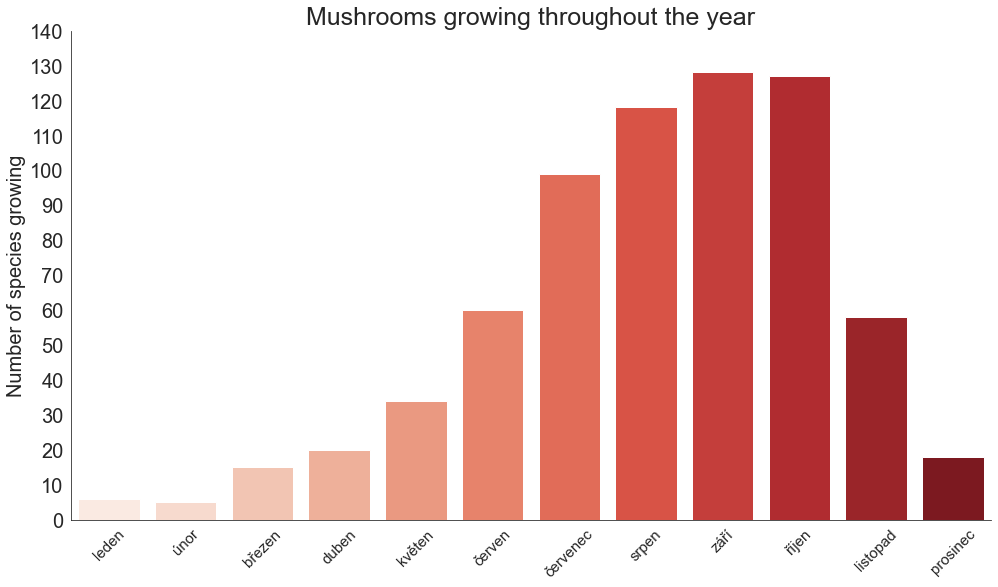

In [15]:
size = (16.5, 9)
fig, ax = plt.subplots(figsize=size)

sns.set_style('white')
ax = sns.barplot(y="month", x=month_freq.index, data=month_freq, palette = 'Reds')
sns.despine()
plt.xticks(rotation= 45, fontsize = 15)
plt.yticks(fontsize = 20)
ax.set_ylabel('Number of species growing', fontsize = 20)
ax.set_title('Mushrooms growing throughout the year', fontsize = 25)
ax.set_yticks(list(range(0,150, 10)));

# PLOT PLACE

In [16]:
places = ['jehličnatý les', 'kosodřevina', 'křoviny',
       'listnatý les', 'louky', 'mýtiny', 'parky', 'paseky', 'pastviny',
       'pole', 'rašeliniště', 'sady', 'smíšený les', 'stráně', 'zahrady']

places_freq = pd.DataFrame(df[places].apply(sum, axis = 0), columns = ['place'])
places_freq['place'] = places_freq['place'].astype(int)
places_freq = pd.DataFrame(places_freq['place'].sort_values(ascending = False))

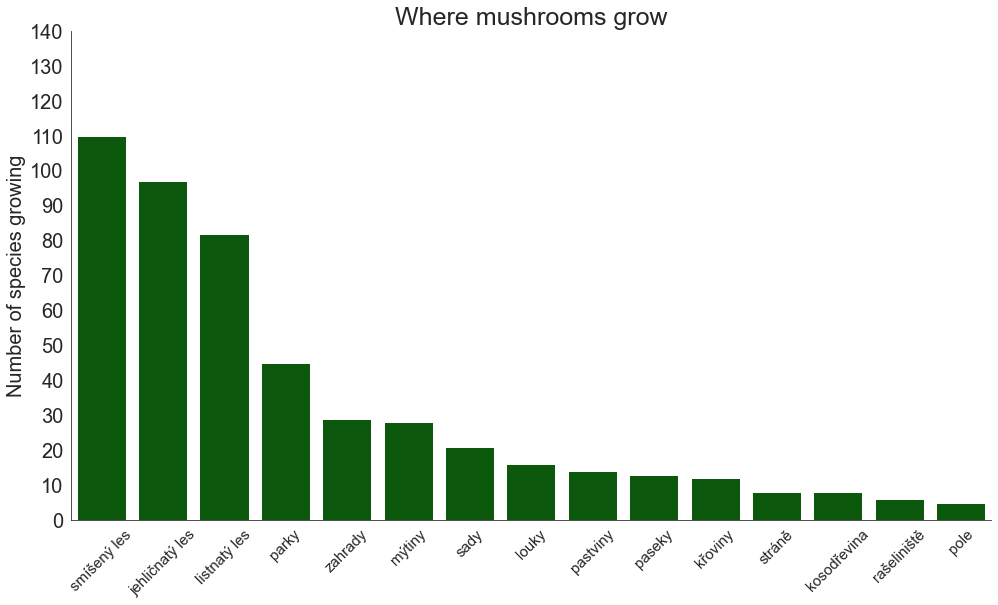

In [17]:
size = (16.5, 9)
fig, ax = plt.subplots(figsize=size)

sns.set_style('white')
ax = sns.barplot(y="place", x=places_freq.index, data=places_freq, color = '#006400')
sns.despine()
plt.xticks(rotation= 45, fontsize = 15)
plt.yticks(fontsize = 20)
ax.set_ylabel('Number of species growing', fontsize = 20)
ax.set_title('Where mushrooms grow', fontsize = 25)
ax.set_yticks(list(range(0,150, 10)));

# PLOT OTHER CHARACTERISTICS

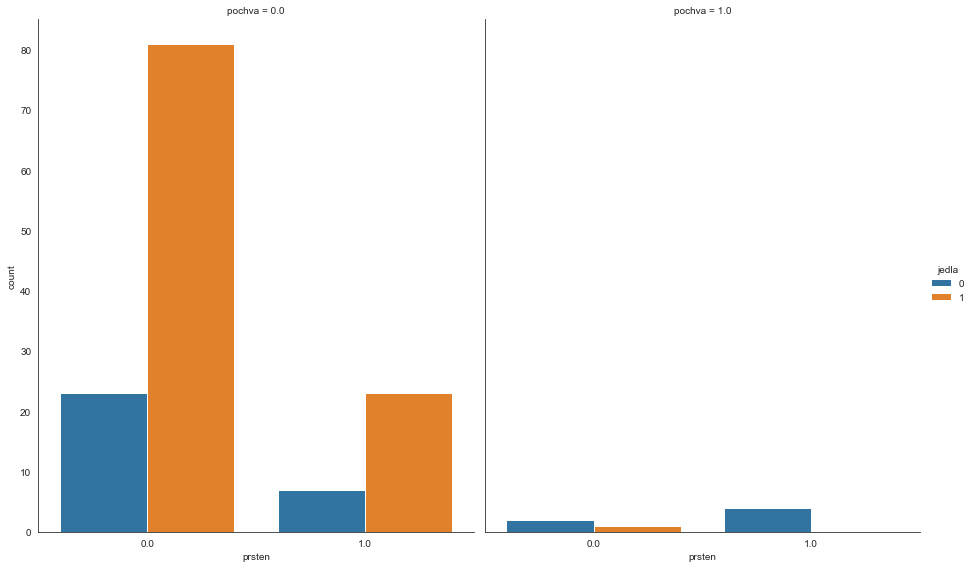

In [18]:
g = sns.catplot(x="prsten", hue="jedla", col="pochva",
                data=df, kind="count",
                height=8, aspect=0.8);

# Predictive modelling

In [168]:
# create copy of original df 
df_glm = df.copy()

In [169]:
# which cols to binarize & one hot encode
cols_to_binarize = ['klobouk_barva', 'klobouk_povrch', 'klobouk_tvar',
                    'konzistence', 'tren_barva', 'tren_povrch', 'tren_tvar'] 

# drop useless columns - smell, places and months
df_glm = df_glm.drop(columns = ['vune'])
df_glm = df_glm.drop(columns = months_cz)
df_glm = df_glm.drop(columns = places)

# convert all columns to list
df_glm[cols_to_binarize] = df_glm[cols_to_binarize].applymap(to_list)

## Data preprocessing

In [170]:
# series for each variable
col2bin1 = df_glm['klobouk_barva']
col2bin2 = df_glm['klobouk_povrch']
col2bin3 = df_glm['klobouk_tvar']
col2bin4 = df_glm['konzistence']
col2bin5 = df_glm['tren_barva']
col2bin6 = df_glm['tren_povrch']
col2bin7 = df_glm['tren_tvar']

In [171]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# create column out of each value of each column & binarize
bin1 = pd.DataFrame(mlb.fit_transform(col2bin1), columns = mlb.classes_, index = df_glm.index).add_suffix('_klobouk_b')
bin2 = pd.DataFrame(mlb.fit_transform(col2bin2), columns = mlb.classes_, index = df_glm.index).add_suffix('_klobouk_p')
bin3 = pd.DataFrame(mlb.fit_transform(col2bin3), columns = mlb.classes_, index = df_glm.index).add_suffix('_klobouk_t')
bin4 = pd.DataFrame(mlb.fit_transform(col2bin4), columns = mlb.classes_, index = df_glm.index).add_suffix('_konzistence')
bin5 = pd.DataFrame(mlb.fit_transform(col2bin5), columns = mlb.classes_, index = df_glm.index).add_suffix('_tren_b')
bin6 = pd.DataFrame(mlb.fit_transform(col2bin6), columns = mlb.classes_, index = df_glm.index).add_suffix('_tren_p')
bin7 = pd.DataFrame(mlb.fit_transform(col2bin7), columns = mlb.classes_, index = df_glm.index).add_suffix('_tren_t')

In [172]:
# drop columns
df_glm = df_glm.drop(columns = cols_to_binarize)

# merge with binarized columns
df_glm = df_glm.merge(bin1, right_index = True, left_index = True, how = 'left')
df_glm = df_glm.merge(bin2, right_index = True, left_index = True, how = 'left')
df_glm = df_glm.merge(bin3, right_index = True, left_index = True, how = 'left')
df_glm = df_glm.merge(bin4, right_index = True, left_index = True, how = 'left')
df_glm = df_glm.merge(bin5, right_index = True, left_index = True, how = 'left')
df_glm = df_glm.merge(bin6, right_index = True, left_index = True, how = 'left')
df_glm = df_glm.merge(bin7, right_index = True, left_index = True, how = 'left')


In [173]:
from sklearn.preprocessing import OneHotEncoder

# which cols to drop - aren't useful features
cols_not_features = ['latin', 'rod', 'jiné']
features = df_glm.loc[:,~df_glm.columns.isin(cols_not_features)]

# one hot encode one variable
enc = OneHotEncoder()
hymenofor_enc = enc.fit_transform(features[['hymenofor']])
hymenofor_enc = pd.DataFrame(hymenofor_enc.toarray(), columns = enc.categories_)

# create final df
features = features.drop(columns = ['hymenofor'])
hymenofor_enc = hymenofor_enc.set_index(df_glm.index)
features = pd.concat([features, hymenofor_enc], axis=1)

In [174]:
# create X and y (target variable and features)
y = features.pop('jedla')
X = features

# see frequencies of each variable
features_freq = features.apply(sum, axis = 0).sort_values()
features_freq

prohloubený_klobouk_t      1.0
tečkovaný_tren_p           1.0
chlupatý_tren_p            1.0
ojíněný_tren_p             1.0
olivová_tren_b             2.0
                         ...  
hnědá_klobouk_b           73.0
klenutý_klobouk_t         75.0
(lupeny,)                 83.0
plochý_klobouk_t          94.0
válcovitý_tren_t         115.0
Length: 86, dtype: float64

### Split into train, test and validation datasets

In [175]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1, stratify = y_train)

In [176]:
print(len(X_train), len(X_test), len(y_train), len(y_test), len(X_val), len(y_val))

print('Train set:     ', np.unique(y_train, return_counts = True))
print('Validation set:', np.unique(y_val, return_counts = True))
print('Test set:      ', np.unique(y_test, return_counts = True))

89 29 89 29 23 23
Train set:      (array([0, 1], dtype=int64), array([23, 66], dtype=int64))
Validation set: (array([0, 1], dtype=int64), array([ 6, 17], dtype=int64))
Test set:       (array([0, 1], dtype=int64), array([ 7, 22], dtype=int64))


## MachineLearning models tryout

In [143]:
# set up GLM, random forest, SVC, MLP and NB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB


glm_clf = LogisticRegression(random_state = 1, class_weight = 'balanced')
rfc_clf = RandomForestClassifier(random_state=42, class_weight = 'balanced')
svm_clf = SVC(random_state=42, class_weight = 'balanced')
mlp_clf = MLPClassifier(max_iter = 500, random_state=42)
gnb_clf = GaussianNB()

In [144]:
# train each estimator and evaluate using f1 score, because it is an appropriate metric here
# - maximalizing both precision and recall is better than focusing on e.g. accuracy alone

from sklearn.metrics import f1_score

estimators = [glm_clf, rfc_clf, mlp_clf, gnb_clf, svm_clf]
for index, estimator in enumerate(estimators):
    print("Training estimator", type(estimator).__name__)
    y_pred = estimator.fit(X_train, y_train).predict(X_val)
    print('f1 score:', round(f1_score(y_pred, y_val),3), '\n')
    

Training estimator LogisticRegression
f1 score: 0.688 

Training estimator RandomForestClassifier
f1 score: 0.811 

Training estimator MLPClassifier
f1 score: 0.765 

Training estimator GaussianNB
f1 score: 0.571 

Training estimator SVC
f1 score: 0.706 



In [30]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

# Crossvalidation - try to validate models also using a stratified KFold technieque 
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 1)

for index, estimator in enumerate(estimators):
    scores = cross_val_score(estimator.fit(X_train, y_train), X_train, y_train, scoring = 'f1', cv = cv)
    print('Mean f1 for estimator',type(estimator).__name__,': %.3f' % np.mean(scores))

Mean f1 for estimator LogisticRegression : 0.775
Mean f1 for estimator RandomForestClassifier : 0.855
Mean f1 for estimator MLPClassifier : 0.835
Mean f1 for estimator GaussianNB : 0.684
Mean f1 for estimator SVC : 0.797


It seems like the best model with the highest f1 score is the RFC, SVC, MLP and GLM. We can easily discard NB and MLP classifiers. Let's explore further.

### Performance on validation dataset for chosen models

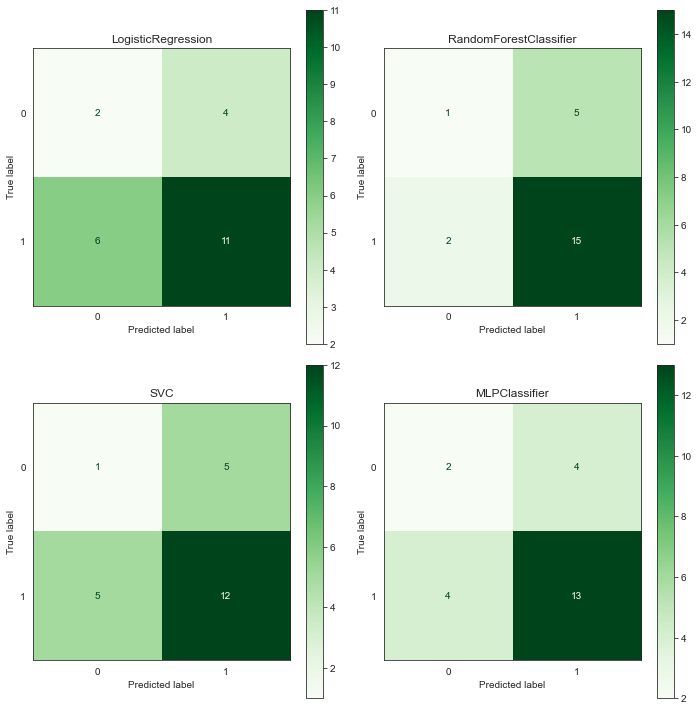

In [31]:
from sklearn.metrics import plot_confusion_matrix

estimators = [glm_clf, rfc_clf, svm_clf, mlp_clf]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

for cls, ax in zip(estimators, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_val, 
                          y_val, 
                          ax=ax, 
                          cmap='Greens')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  

It seems like the RFC algorithm has simply learned to classify most labels as 1 - that is not ideal, we want to avoid mushrooms that are poisonous at the cost of evaluating edible ones as inedible, rather than the other way around.

From the rest, the best models seem to be MLP and Logistic Regression for this problem - simply because they have the least FP. 

### Find best hyper parameters - Tuning MLP

In [41]:
from sklearn.model_selection import GridSearchCV

# choose parameter differences
#param_grid = [{'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.4, 0.5, 1, 2, 3]}]

param_grid = [{'activation': ['relu', 'logistic', 'tanh'],
              'solver': ['adam', 'lbfgs', 'sgd'],
              'hidden_layer_sizes': [(100,), (50,), (200,)],
              'alpha': [0.0001, 0.00001]}]

# fit a new model!
mlp_clf2 = MLPClassifier(max_iter = 500, random_state=42)
#glm_2 = LogisticRegression(random_state = 1, class_weight = 'balanced')
grid_search = GridSearchCV(mlp_clf2, param_grid, cv=cv,
                           scoring= 'f1',
                           return_train_score=True)

# search
grid_search.fit(X_train, y_train);

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

In [42]:
# see best parameters to maximize f1 score on training set.

print(grid_search.best_params_)

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (200,), 'solver': 'sgd'}


#### Fit with new hyper parameters

In [44]:
mlp_final = MLPClassifier(random_state = 43, 
                               activation = 'tanh',
                               alpha = 0.0001,
                               hidden_layer_sizes = (200,),
                               solver = 'sgd',
                               max_iter = 500,
                               verbose = True)

mlp_fit_final = mlp_final.fit(X_train, y_train)
y_pred_final_mlp = mlp_fit_final.predict(X_val)


scores = cross_val_score(mlp_fit_final, X_train, y_train, scoring = 'f1', cv = cv)
print('Mean f1 for MLP: %.3f' % np.mean(scores))

Iteration 1, loss = 0.74710881
Iteration 2, loss = 0.74440691
Iteration 3, loss = 0.74060570
Iteration 4, loss = 0.73586778
Iteration 5, loss = 0.73034829
Iteration 6, loss = 0.72419299
Iteration 7, loss = 0.71753701
Iteration 8, loss = 0.71050398
Iteration 9, loss = 0.70320565
Iteration 10, loss = 0.69574179
Iteration 11, loss = 0.68820036
Iteration 12, loss = 0.68065793
Iteration 13, loss = 0.67318016
Iteration 14, loss = 0.66582247
Iteration 15, loss = 0.65863081
Iteration 16, loss = 0.65164239
Iteration 17, loss = 0.64488651
Iteration 18, loss = 0.63838541
Iteration 19, loss = 0.63215502
Iteration 20, loss = 0.62620576
Iteration 21, loss = 0.62054331
Iteration 22, loss = 0.61516924
Iteration 23, loss = 0.61008172
Iteration 24, loss = 0.60527606
Iteration 25, loss = 0.60074529
Iteration 26, loss = 0.59648057
Iteration 27, loss = 0.59247168
Iteration 28, loss = 0.58870736
Iteration 29, loss = 0.58517562
Iteration 30, loss = 0.58186403
Iteration 31, loss = 0.57875996
Iteration 32, los

Iteration 313, loss = 0.41129839
Iteration 314, loss = 0.41095872
Iteration 315, loss = 0.41061974
Iteration 316, loss = 0.41028145
Iteration 317, loss = 0.40994384
Iteration 318, loss = 0.40960691
Iteration 319, loss = 0.40927065
Iteration 320, loss = 0.40893507
Iteration 321, loss = 0.40860015
Iteration 322, loss = 0.40826590
Iteration 323, loss = 0.40793232
Iteration 324, loss = 0.40759940
Iteration 325, loss = 0.40726713
Iteration 326, loss = 0.40693552
Iteration 327, loss = 0.40660456
Iteration 328, loss = 0.40627425
Iteration 329, loss = 0.40594458
Iteration 330, loss = 0.40561556
Iteration 331, loss = 0.40528718
Iteration 332, loss = 0.40495943
Iteration 333, loss = 0.40463232
Iteration 334, loss = 0.40430584
Iteration 335, loss = 0.40397998
Iteration 336, loss = 0.40365476
Iteration 337, loss = 0.40333016
Iteration 338, loss = 0.40300617
Iteration 339, loss = 0.40268281
Iteration 340, loss = 0.40236006
Iteration 341, loss = 0.40203792
Iteration 342, loss = 0.40171639
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 58, loss = 0.54123616
Iteration 59, loss = 0.54039349
Iteration 60, loss = 0.53956801
Iteration 61, loss = 0.53875823
Iteration 62, loss = 0.53796278
Iteration 63, loss = 0.53718046
Iteration 64, loss = 0.53641015
Iteration 65, loss = 0.53565088
Iteration 66, loss = 0.53490174
Iteration 67, loss = 0.53416194
Iteration 68, loss = 0.53343074
Iteration 69, loss = 0.53270751
Iteration 70, loss = 0.53199164
Iteration 71, loss = 0.53128263
Iteration 72, loss = 0.53057999
Iteration 73, loss = 0.52988331
Iteration 74, loss = 0.52919220
Iteration 75, loss = 0.52850633
Iteration 76, loss = 0.52782539
Iteration 77, loss = 0.52714910
Iteration 78, loss = 0.52647722
Iteration 79, loss = 0.52580953
Iteration 80, loss = 0.52514584
Iteration 81, loss = 0.52448596
Iteration 82, loss = 0.52382974
Iteration 83, loss = 0.52317703
Iteration 84, loss = 0.52252771
Iteration 85, loss = 0.52188165
Iteration 86, loss = 0.52123876
Iteration 87, loss = 0.52059894
Iteration 88, loss = 0.51996210
Iteratio

Iteration 328, loss = 0.41221209
Iteration 329, loss = 0.41187618
Iteration 330, loss = 0.41154087
Iteration 331, loss = 0.41120614
Iteration 332, loss = 0.41087200
Iteration 333, loss = 0.41053845
Iteration 334, loss = 0.41020547
Iteration 335, loss = 0.40987307
Iteration 336, loss = 0.40954125
Iteration 337, loss = 0.40921000
Iteration 338, loss = 0.40887932
Iteration 339, loss = 0.40854921
Iteration 340, loss = 0.40821967
Iteration 341, loss = 0.40789069
Iteration 342, loss = 0.40756228
Iteration 343, loss = 0.40723442
Iteration 344, loss = 0.40690712
Iteration 345, loss = 0.40658038
Iteration 346, loss = 0.40625419
Iteration 347, loss = 0.40592855
Iteration 348, loss = 0.40560346
Iteration 349, loss = 0.40527892
Iteration 350, loss = 0.40495492
Iteration 351, loss = 0.40463146
Iteration 352, loss = 0.40430854
Iteration 353, loss = 0.40398617
Iteration 354, loss = 0.40366432
Iteration 355, loss = 0.40334301
Iteration 356, loss = 0.40302224
Iteration 357, loss = 0.40270199
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 37, loss = 0.56866631
Iteration 38, loss = 0.56664121
Iteration 39, loss = 0.56473055
Iteration 40, loss = 0.56292535
Iteration 41, loss = 0.56121718
Iteration 42, loss = 0.55959815
Iteration 43, loss = 0.55806087
Iteration 44, loss = 0.55659850
Iteration 45, loss = 0.55520465
Iteration 46, loss = 0.55387343
Iteration 47, loss = 0.55259941
Iteration 48, loss = 0.55137757
Iteration 49, loss = 0.55020330
Iteration 50, loss = 0.54907238
Iteration 51, loss = 0.54798094
Iteration 52, loss = 0.54692544
Iteration 53, loss = 0.54590266
Iteration 54, loss = 0.54490965
Iteration 55, loss = 0.54394374
Iteration 56, loss = 0.54300250
Iteration 57, loss = 0.54208373
Iteration 58, loss = 0.54118542
Iteration 59, loss = 0.54030577
Iteration 60, loss = 0.53944314
Iteration 61, loss = 0.53859606
Iteration 62, loss = 0.53776318
Iteration 63, loss = 0.53694331
Iteration 64, loss = 0.53613537
Iteration 65, loss = 0.53533838
Iteration 66, loss = 0.53455147
Iteration 67, loss = 0.53377384
Iteratio

Iteration 307, loss = 0.41403084
Iteration 308, loss = 0.41367403
Iteration 309, loss = 0.41331793
Iteration 310, loss = 0.41296254
Iteration 311, loss = 0.41260786
Iteration 312, loss = 0.41225388
Iteration 313, loss = 0.41190060
Iteration 314, loss = 0.41154801
Iteration 315, loss = 0.41119612
Iteration 316, loss = 0.41084492
Iteration 317, loss = 0.41049440
Iteration 318, loss = 0.41014457
Iteration 319, loss = 0.40979542
Iteration 320, loss = 0.40944695
Iteration 321, loss = 0.40909915
Iteration 322, loss = 0.40875202
Iteration 323, loss = 0.40840556
Iteration 324, loss = 0.40805977
Iteration 325, loss = 0.40771464
Iteration 326, loss = 0.40737017
Iteration 327, loss = 0.40702636
Iteration 328, loss = 0.40668320
Iteration 329, loss = 0.40634070
Iteration 330, loss = 0.40599884
Iteration 331, loss = 0.40565763
Iteration 332, loss = 0.40531706
Iteration 333, loss = 0.40497713
Iteration 334, loss = 0.40463784
Iteration 335, loss = 0.40429918
Iteration 336, loss = 0.40396116
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 40, loss = 0.55590862
Iteration 41, loss = 0.55424568
Iteration 42, loss = 0.55266796
Iteration 43, loss = 0.55116793
Iteration 44, loss = 0.54973863
Iteration 45, loss = 0.54837364
Iteration 46, loss = 0.54706708
Iteration 47, loss = 0.54581352
Iteration 48, loss = 0.54460803
Iteration 49, loss = 0.54344610
Iteration 50, loss = 0.54232360
Iteration 51, loss = 0.54123682
Iteration 52, loss = 0.54018235
Iteration 53, loss = 0.53915712
Iteration 54, loss = 0.53815836
Iteration 55, loss = 0.53718357
Iteration 56, loss = 0.53623048
Iteration 57, loss = 0.53529705
Iteration 58, loss = 0.53438147
Iteration 59, loss = 0.53348208
Iteration 60, loss = 0.53259743
Iteration 61, loss = 0.53172618
Iteration 62, loss = 0.53086717
Iteration 63, loss = 0.53001934
Iteration 64, loss = 0.52918176
Iteration 65, loss = 0.52835358
Iteration 66, loss = 0.52753406
Iteration 67, loss = 0.52672255
Iteration 68, loss = 0.52591844
Iteration 69, loss = 0.52512122
Iteration 70, loss = 0.52433043
Iterati

Iteration 319, loss = 0.39738247
Iteration 320, loss = 0.39703077
Iteration 321, loss = 0.39667982
Iteration 322, loss = 0.39632962
Iteration 323, loss = 0.39598017
Iteration 324, loss = 0.39563146
Iteration 325, loss = 0.39528349
Iteration 326, loss = 0.39493625
Iteration 327, loss = 0.39458975
Iteration 328, loss = 0.39424397
Iteration 329, loss = 0.39389892
Iteration 330, loss = 0.39355459
Iteration 331, loss = 0.39321098
Iteration 332, loss = 0.39286809
Iteration 333, loss = 0.39252590
Iteration 334, loss = 0.39218443
Iteration 335, loss = 0.39184366
Iteration 336, loss = 0.39150359
Iteration 337, loss = 0.39116422
Iteration 338, loss = 0.39082554
Iteration 339, loss = 0.39048756
Iteration 340, loss = 0.39015026
Iteration 341, loss = 0.38981365
Iteration 342, loss = 0.38947772
Iteration 343, loss = 0.38914248
Iteration 344, loss = 0.38880790
Iteration 345, loss = 0.38847401
Iteration 346, loss = 0.38814078
Iteration 347, loss = 0.38780822
Iteration 348, loss = 0.38747632
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 31, loss = 0.57457361
Iteration 32, loss = 0.57161972
Iteration 33, loss = 0.56884269
Iteration 34, loss = 0.56623082
Iteration 35, loss = 0.56377277
Iteration 36, loss = 0.56145758
Iteration 37, loss = 0.55927473
Iteration 38, loss = 0.55721423
Iteration 39, loss = 0.55526659
Iteration 40, loss = 0.55342285
Iteration 41, loss = 0.55167461
Iteration 42, loss = 0.55001401
Iteration 43, loss = 0.54843371
Iteration 44, loss = 0.54692689
Iteration 45, loss = 0.54548723
Iteration 46, loss = 0.54410889
Iteration 47, loss = 0.54278648
Iteration 48, loss = 0.54151504
Iteration 49, loss = 0.54029003
Iteration 50, loss = 0.53910727
Iteration 51, loss = 0.53796296
Iteration 52, loss = 0.53685361
Iteration 53, loss = 0.53577604
Iteration 54, loss = 0.53472739
Iteration 55, loss = 0.53370501
Iteration 56, loss = 0.53270654
Iteration 57, loss = 0.53172982
Iteration 58, loss = 0.53077290
Iteration 59, loss = 0.52983401
Iteration 60, loss = 0.52891157
Iteration 61, loss = 0.52800413
Iteratio

Iteration 330, loss = 0.38070936
Iteration 331, loss = 0.38032650
Iteration 332, loss = 0.37994437
Iteration 333, loss = 0.37956296
Iteration 334, loss = 0.37918228
Iteration 335, loss = 0.37880232
Iteration 336, loss = 0.37842308
Iteration 337, loss = 0.37804456
Iteration 338, loss = 0.37766675
Iteration 339, loss = 0.37728965
Iteration 340, loss = 0.37691325
Iteration 341, loss = 0.37653757
Iteration 342, loss = 0.37616258
Iteration 343, loss = 0.37578829
Iteration 344, loss = 0.37541470
Iteration 345, loss = 0.37504180
Iteration 346, loss = 0.37466960
Iteration 347, loss = 0.37429808
Iteration 348, loss = 0.37392725
Iteration 349, loss = 0.37355710
Iteration 350, loss = 0.37318763
Iteration 351, loss = 0.37281884
Iteration 352, loss = 0.37245072
Iteration 353, loss = 0.37208328
Iteration 354, loss = 0.37171651
Iteration 355, loss = 0.37135040
Iteration 356, loss = 0.37098496
Iteration 357, loss = 0.37062018
Iteration 358, loss = 0.37025606
Iteration 359, loss = 0.36989260
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 11, loss = 0.69113386
Iteration 12, loss = 0.68376925
Iteration 13, loss = 0.67646640
Iteration 14, loss = 0.66927920
Iteration 15, loss = 0.66225223
Iteration 16, loss = 0.65542157
Iteration 17, loss = 0.64881561
Iteration 18, loss = 0.64245581
Iteration 19, loss = 0.63635752
Iteration 20, loss = 0.63053072
Iteration 21, loss = 0.62498075
Iteration 22, loss = 0.61970899
Iteration 23, loss = 0.61471351
Iteration 24, loss = 0.60998961
Iteration 25, loss = 0.60553036
Iteration 26, loss = 0.60132705
Iteration 27, loss = 0.59736965
Iteration 28, loss = 0.59364710
Iteration 29, loss = 0.59014768
Iteration 30, loss = 0.58685924
Iteration 31, loss = 0.58376945
Iteration 32, loss = 0.58086597
Iteration 33, loss = 0.57813660
Iteration 34, loss = 0.57556943
Iteration 35, loss = 0.57315291
Iteration 36, loss = 0.57087593
Iteration 37, loss = 0.56872788
Iteration 38, loss = 0.56669869
Iteration 39, loss = 0.56477884
Iteration 40, loss = 0.56295938
Iteration 41, loss = 0.56123193
Iterati

Iteration 319, loss = 0.39747328
Iteration 320, loss = 0.39711707
Iteration 321, loss = 0.39676167
Iteration 322, loss = 0.39640709
Iteration 323, loss = 0.39605331
Iteration 324, loss = 0.39570033
Iteration 325, loss = 0.39534815
Iteration 326, loss = 0.39499677
Iteration 327, loss = 0.39464618
Iteration 328, loss = 0.39429637
Iteration 329, loss = 0.39394735
Iteration 330, loss = 0.39359911
Iteration 331, loss = 0.39325165
Iteration 332, loss = 0.39290496
Iteration 333, loss = 0.39255904
Iteration 334, loss = 0.39221388
Iteration 335, loss = 0.39186948
Iteration 336, loss = 0.39152585
Iteration 337, loss = 0.39118296
Iteration 338, loss = 0.39084083
Iteration 339, loss = 0.39049945
Iteration 340, loss = 0.39015881
Iteration 341, loss = 0.38981891
Iteration 342, loss = 0.38947975
Iteration 343, loss = 0.38914132
Iteration 344, loss = 0.38880362
Iteration 345, loss = 0.38846665
Iteration 346, loss = 0.38813041
Iteration 347, loss = 0.38779488
Iteration 348, loss = 0.38746007
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 27, loss = 0.59577087
Iteration 28, loss = 0.59197106
Iteration 29, loss = 0.58840766
Iteration 30, loss = 0.58506765
Iteration 31, loss = 0.58193782
Iteration 32, loss = 0.57900500
Iteration 33, loss = 0.57625620
Iteration 34, loss = 0.57367873
Iteration 35, loss = 0.57126032
Iteration 36, loss = 0.56898917
Iteration 37, loss = 0.56685403
Iteration 38, loss = 0.56484422
Iteration 39, loss = 0.56294966
Iteration 40, loss = 0.56116089
Iteration 41, loss = 0.55946903
Iteration 42, loss = 0.55786583
Iteration 43, loss = 0.55634360
Iteration 44, loss = 0.55489523
Iteration 45, loss = 0.55351416
Iteration 46, loss = 0.55219433
Iteration 47, loss = 0.55093019
Iteration 48, loss = 0.54971663
Iteration 49, loss = 0.54854900
Iteration 50, loss = 0.54742304
Iteration 51, loss = 0.54633486
Iteration 52, loss = 0.54528095
Iteration 53, loss = 0.54425810
Iteration 54, loss = 0.54326340
Iteration 55, loss = 0.54229422
Iteration 56, loss = 0.54134818
Iteration 57, loss = 0.54042314
Iterati

Iteration 279, loss = 0.41857503
Iteration 280, loss = 0.41818282
Iteration 281, loss = 0.41779144
Iteration 282, loss = 0.41740089
Iteration 283, loss = 0.41701116
Iteration 284, loss = 0.41662226
Iteration 285, loss = 0.41623418
Iteration 286, loss = 0.41584691
Iteration 287, loss = 0.41546045
Iteration 288, loss = 0.41507479
Iteration 289, loss = 0.41468994
Iteration 290, loss = 0.41430589
Iteration 291, loss = 0.41392263
Iteration 292, loss = 0.41354016
Iteration 293, loss = 0.41315847
Iteration 294, loss = 0.41277757
Iteration 295, loss = 0.41239744
Iteration 296, loss = 0.41201809
Iteration 297, loss = 0.41163951
Iteration 298, loss = 0.41126169
Iteration 299, loss = 0.41088464
Iteration 300, loss = 0.41050835
Iteration 301, loss = 0.41013282
Iteration 302, loss = 0.40975803
Iteration 303, loss = 0.40938399
Iteration 304, loss = 0.40901070
Iteration 305, loss = 0.40863815
Iteration 306, loss = 0.40826634
Iteration 307, loss = 0.40789526
Iteration 308, loss = 0.40752491
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 23, loss = 0.61030933
Iteration 24, loss = 0.60524472
Iteration 25, loss = 0.60046846
Iteration 26, loss = 0.59597162
Iteration 27, loss = 0.59174377
Iteration 28, loss = 0.58777338
Iteration 29, loss = 0.58404816
Iteration 30, loss = 0.58055529
Iteration 31, loss = 0.57728174
Iteration 32, loss = 0.57421442
Iteration 33, loss = 0.57134035
Iteration 34, loss = 0.56864681
Iteration 35, loss = 0.56612145
Iteration 36, loss = 0.56375234
Iteration 37, loss = 0.56152806
Iteration 38, loss = 0.55943773
Iteration 39, loss = 0.55747105
Iteration 40, loss = 0.55561828
Iteration 41, loss = 0.55387030
Iteration 42, loss = 0.55221854
Iteration 43, loss = 0.55065505
Iteration 44, loss = 0.54917239
Iteration 45, loss = 0.54776369
Iteration 46, loss = 0.54642258
Iteration 47, loss = 0.54514319
Iteration 48, loss = 0.54392012
Iteration 49, loss = 0.54274839
Iteration 50, loss = 0.54162344
Iteration 51, loss = 0.54054109
Iteration 52, loss = 0.53949754
Iteration 53, loss = 0.53848928
Iterati

Iteration 292, loss = 0.41754000
Iteration 293, loss = 0.41718546
Iteration 294, loss = 0.41683163
Iteration 295, loss = 0.41647852
Iteration 296, loss = 0.41612612
Iteration 297, loss = 0.41577442
Iteration 298, loss = 0.41542343
Iteration 299, loss = 0.41507314
Iteration 300, loss = 0.41472354
Iteration 301, loss = 0.41437464
Iteration 302, loss = 0.41402642
Iteration 303, loss = 0.41367890
Iteration 304, loss = 0.41333206
Iteration 305, loss = 0.41298589
Iteration 306, loss = 0.41264041
Iteration 307, loss = 0.41229560
Iteration 308, loss = 0.41195146
Iteration 309, loss = 0.41160798
Iteration 310, loss = 0.41126518
Iteration 311, loss = 0.41092303
Iteration 312, loss = 0.41058155
Iteration 313, loss = 0.41024072
Iteration 314, loss = 0.40990054
Iteration 315, loss = 0.40956101
Iteration 316, loss = 0.40922213
Iteration 317, loss = 0.40888389
Iteration 318, loss = 0.40854630
Iteration 319, loss = 0.40820934
Iteration 320, loss = 0.40787302
Iteration 321, loss = 0.40753733
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 57, loss = 0.52788655
Iteration 58, loss = 0.52704088
Iteration 59, loss = 0.52621321
Iteration 60, loss = 0.52540190
Iteration 61, loss = 0.52460549
Iteration 62, loss = 0.52382265
Iteration 63, loss = 0.52305222
Iteration 64, loss = 0.52229311
Iteration 65, loss = 0.52154437
Iteration 66, loss = 0.52080516
Iteration 67, loss = 0.52007469
Iteration 68, loss = 0.51935229
Iteration 69, loss = 0.51863733
Iteration 70, loss = 0.51792928
Iteration 71, loss = 0.51722763
Iteration 72, loss = 0.51653195
Iteration 73, loss = 0.51584185
Iteration 74, loss = 0.51515698
Iteration 75, loss = 0.51447702
Iteration 76, loss = 0.51380170
Iteration 77, loss = 0.51313077
Iteration 78, loss = 0.51246402
Iteration 79, loss = 0.51180123
Iteration 80, loss = 0.51114223
Iteration 81, loss = 0.51048687
Iteration 82, loss = 0.50983501
Iteration 83, loss = 0.50918652
Iteration 84, loss = 0.50854129
Iteration 85, loss = 0.50789921
Iteration 86, loss = 0.50726020
Iteration 87, loss = 0.50662418
Iteratio

Iteration 326, loss = 0.40009773
Iteration 327, loss = 0.39976479
Iteration 328, loss = 0.39943243
Iteration 329, loss = 0.39910063
Iteration 330, loss = 0.39876939
Iteration 331, loss = 0.39843871
Iteration 332, loss = 0.39810859
Iteration 333, loss = 0.39777903
Iteration 334, loss = 0.39745001
Iteration 335, loss = 0.39712155
Iteration 336, loss = 0.39679363
Iteration 337, loss = 0.39646626
Iteration 338, loss = 0.39613943
Iteration 339, loss = 0.39581313
Iteration 340, loss = 0.39548738
Iteration 341, loss = 0.39516216
Iteration 342, loss = 0.39483747
Iteration 343, loss = 0.39451331
Iteration 344, loss = 0.39418967
Iteration 345, loss = 0.39386657
Iteration 346, loss = 0.39354398
Iteration 347, loss = 0.39322192
Iteration 348, loss = 0.39290037
Iteration 349, loss = 0.39257933
Iteration 350, loss = 0.39225881
Iteration 351, loss = 0.39193880
Iteration 352, loss = 0.39161930
Iteration 353, loss = 0.39130031
Iteration 354, loss = 0.39098182
Iteration 355, loss = 0.39066383
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 6, loss = 0.71972446
Iteration 7, loss = 0.71266232
Iteration 8, loss = 0.70520518
Iteration 9, loss = 0.69747249
Iteration 10, loss = 0.68957075
Iteration 11, loss = 0.68159371
Iteration 12, loss = 0.67362277
Iteration 13, loss = 0.66572757
Iteration 14, loss = 0.65796670
Iteration 15, loss = 0.65038847
Iteration 16, loss = 0.64303183
Iteration 17, loss = 0.63592719
Iteration 18, loss = 0.62909736
Iteration 19, loss = 0.62255843
Iteration 20, loss = 0.61632060
Iteration 21, loss = 0.61038901
Iteration 22, loss = 0.60476447
Iteration 23, loss = 0.59944419
Iteration 24, loss = 0.59442244
Iteration 25, loss = 0.58969105
Iteration 26, loss = 0.58523999
Iteration 27, loss = 0.58105784
Iteration 28, loss = 0.57713209
Iteration 29, loss = 0.57344960
Iteration 30, loss = 0.56999679
Iteration 31, loss = 0.56675996
Iteration 32, loss = 0.56372542
Iteration 33, loss = 0.56087972
Iteration 34, loss = 0.55820972
Iteration 35, loss = 0.55570274
Iteration 36, loss = 0.55334661
Iteration 3

Iteration 265, loss = 0.40081356
Iteration 266, loss = 0.40039893
Iteration 267, loss = 0.39998536
Iteration 268, loss = 0.39957284
Iteration 269, loss = 0.39916136
Iteration 270, loss = 0.39875092
Iteration 271, loss = 0.39834151
Iteration 272, loss = 0.39793314
Iteration 273, loss = 0.39752579
Iteration 274, loss = 0.39711945
Iteration 275, loss = 0.39671414
Iteration 276, loss = 0.39630982
Iteration 277, loss = 0.39590652
Iteration 278, loss = 0.39550421
Iteration 279, loss = 0.39510290
Iteration 280, loss = 0.39470258
Iteration 281, loss = 0.39430324
Iteration 282, loss = 0.39390488
Iteration 283, loss = 0.39350749
Iteration 284, loss = 0.39311108
Iteration 285, loss = 0.39271563
Iteration 286, loss = 0.39232115
Iteration 287, loss = 0.39192761
Iteration 288, loss = 0.39153504
Iteration 289, loss = 0.39114341
Iteration 290, loss = 0.39075272
Iteration 291, loss = 0.39036297
Iteration 292, loss = 0.38997415
Iteration 293, loss = 0.38958626
Iteration 294, loss = 0.38919930
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 2, loss = 0.75021506
Iteration 3, loss = 0.74629837
Iteration 4, loss = 0.74141554
Iteration 5, loss = 0.73572587
Iteration 6, loss = 0.72937902
Iteration 7, loss = 0.72251372
Iteration 8, loss = 0.71525693
Iteration 9, loss = 0.70772346
Iteration 10, loss = 0.70001585
Iteration 11, loss = 0.69222460
Iteration 12, loss = 0.68442849
Iteration 13, loss = 0.67669520
Iteration 14, loss = 0.66908190
Iteration 15, loss = 0.66163606
Iteration 16, loss = 0.65439620
Iteration 17, loss = 0.64739275
Iteration 18, loss = 0.64064883
Iteration 19, loss = 0.63418115
Iteration 20, loss = 0.62800073
Iteration 21, loss = 0.62211368
Iteration 22, loss = 0.61652192
Iteration 23, loss = 0.61122384
Iteration 24, loss = 0.60621487
Iteration 25, loss = 0.60148806
Iteration 26, loss = 0.59703457
Iteration 27, loss = 0.59284409
Iteration 28, loss = 0.58890521
Iteration 29, loss = 0.58520577
Iteration 30, loss = 0.58173314
Iteration 31, loss = 0.57847445
Iteration 32, loss = 0.57541678
Iteration 33, l

Iteration 260, loss = 0.42245356
Iteration 261, loss = 0.42206312
Iteration 262, loss = 0.42167363
Iteration 263, loss = 0.42128509
Iteration 264, loss = 0.42089749
Iteration 265, loss = 0.42051083
Iteration 266, loss = 0.42012509
Iteration 267, loss = 0.41974028
Iteration 268, loss = 0.41935639
Iteration 269, loss = 0.41897341
Iteration 270, loss = 0.41859135
Iteration 271, loss = 0.41821018
Iteration 272, loss = 0.41782992
Iteration 273, loss = 0.41745055
Iteration 274, loss = 0.41707207
Iteration 275, loss = 0.41669448
Iteration 276, loss = 0.41631776
Iteration 277, loss = 0.41594192
Iteration 278, loss = 0.41556695
Iteration 279, loss = 0.41519284
Iteration 280, loss = 0.41481960
Iteration 281, loss = 0.41444721
Iteration 282, loss = 0.41407567
Iteration 283, loss = 0.41370498
Iteration 284, loss = 0.41333513
Iteration 285, loss = 0.41296612
Iteration 286, loss = 0.41259794
Iteration 287, loss = 0.41223059
Iteration 288, loss = 0.41186406
Iteration 289, loss = 0.41149835
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 28, loss = 0.59399774
Iteration 29, loss = 0.59055357
Iteration 30, loss = 0.58732655
Iteration 31, loss = 0.58430396
Iteration 32, loss = 0.58147304
Iteration 33, loss = 0.57882124
Iteration 34, loss = 0.57633626
Iteration 35, loss = 0.57400619
Iteration 36, loss = 0.57181960
Iteration 37, loss = 0.56976556
Iteration 38, loss = 0.56783369
Iteration 39, loss = 0.56601417
Iteration 40, loss = 0.56429779
Iteration 41, loss = 0.56267592
Iteration 42, loss = 0.56114051
Iteration 43, loss = 0.55968405
Iteration 44, loss = 0.55829961
Iteration 45, loss = 0.55698079
Iteration 46, loss = 0.55572166
Iteration 47, loss = 0.55451679
Iteration 48, loss = 0.55336120
Iteration 49, loss = 0.55225033
Iteration 50, loss = 0.55118002
Iteration 51, loss = 0.55014646
Iteration 52, loss = 0.54914619
Iteration 53, loss = 0.54817609
Iteration 54, loss = 0.54723330
Iteration 55, loss = 0.54631525
Iteration 56, loss = 0.54541960
Iteration 57, loss = 0.54454425
Iteration 58, loss = 0.54368730
Iterati

Iteration 308, loss = 0.41848251
Iteration 309, loss = 0.41813727
Iteration 310, loss = 0.41779279
Iteration 311, loss = 0.41744906
Iteration 312, loss = 0.41710608
Iteration 313, loss = 0.41676384
Iteration 314, loss = 0.41642234
Iteration 315, loss = 0.41608159
Iteration 316, loss = 0.41574156
Iteration 317, loss = 0.41540227
Iteration 318, loss = 0.41506371
Iteration 319, loss = 0.41472588
Iteration 320, loss = 0.41438877
Iteration 321, loss = 0.41405237
Iteration 322, loss = 0.41371669
Iteration 323, loss = 0.41338173
Iteration 324, loss = 0.41304747
Iteration 325, loss = 0.41271392
Iteration 326, loss = 0.41238108
Iteration 327, loss = 0.41204894
Iteration 328, loss = 0.41171749
Iteration 329, loss = 0.41138674
Iteration 330, loss = 0.41105668
Iteration 331, loss = 0.41072731
Iteration 332, loss = 0.41039862
Iteration 333, loss = 0.41007062
Iteration 334, loss = 0.40974330
Iteration 335, loss = 0.40941665
Iteration 336, loss = 0.40909068
Iteration 337, loss = 0.40876538
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.71559958
Iteration 8, loss = 0.70863169
Iteration 9, loss = 0.70140179
Iteration 10, loss = 0.69400884
Iteration 11, loss = 0.68654010
Iteration 12, loss = 0.67907149
Iteration 13, loss = 0.67166812
Iteration 14, loss = 0.66438493
Iteration 15, loss = 0.65726744
Iteration 16, loss = 0.65035251
Iteration 17, loss = 0.64366916
Iteration 18, loss = 0.63723936
Iteration 19, loss = 0.63107884
Iteration 20, loss = 0.62519788
Iteration 21, loss = 0.61960203
Iteration 22, loss = 0.61429278
Iteration 23, loss = 0.60926823
Iteration 24, loss = 0.60452368
Iteration 25, loss = 0.60005213
Iteration 26, loss = 0.59584475
Iteration 27, loss = 0.59189135
Iteration 28, loss = 0.58818071
Iteration 29, loss = 0.58470087
Iteration 30, loss = 0.58143947
Iteration 31, loss = 0.57838391
Iteration 32, loss = 0.57552161
Iteration 33, loss = 0.57284010
Iteration 34, loss = 0.57032718
Iteration 35, loss = 0.56797101
Iteration 36, loss = 0.56576022
Iteration 37, loss = 0.56368390
Iteration 3

Iteration 284, loss = 0.42363939
Iteration 285, loss = 0.42327731
Iteration 286, loss = 0.42291600
Iteration 287, loss = 0.42255543
Iteration 288, loss = 0.42219561
Iteration 289, loss = 0.42183654
Iteration 290, loss = 0.42147820
Iteration 291, loss = 0.42112061
Iteration 292, loss = 0.42076375
Iteration 293, loss = 0.42040761
Iteration 294, loss = 0.42005221
Iteration 295, loss = 0.41969752
Iteration 296, loss = 0.41934356
Iteration 297, loss = 0.41899031
Iteration 298, loss = 0.41863778
Iteration 299, loss = 0.41828596
Iteration 300, loss = 0.41793484
Iteration 301, loss = 0.41758442
Iteration 302, loss = 0.41723471
Iteration 303, loss = 0.41688569
Iteration 304, loss = 0.41653737
Iteration 305, loss = 0.41618973
Iteration 306, loss = 0.41584278
Iteration 307, loss = 0.41549652
Iteration 308, loss = 0.41515094
Iteration 309, loss = 0.41480603
Iteration 310, loss = 0.41446180
Iteration 311, loss = 0.41411824
Iteration 312, loss = 0.41377534
Iteration 313, loss = 0.41343312
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 33, loss = 0.57904168
Iteration 34, loss = 0.57649864
Iteration 35, loss = 0.57411277
Iteration 36, loss = 0.57187247
Iteration 37, loss = 0.56976668
Iteration 38, loss = 0.56778486
Iteration 39, loss = 0.56591709
Iteration 40, loss = 0.56415402
Iteration 41, loss = 0.56248688
Iteration 42, loss = 0.56090752
Iteration 43, loss = 0.55940835
Iteration 44, loss = 0.55798233
Iteration 45, loss = 0.55662297
Iteration 46, loss = 0.55532426
Iteration 47, loss = 0.55408071
Iteration 48, loss = 0.55288727
Iteration 49, loss = 0.55173931
Iteration 50, loss = 0.55063263
Iteration 51, loss = 0.54956338
Iteration 52, loss = 0.54852805
Iteration 53, loss = 0.54752348
Iteration 54, loss = 0.54654679
Iteration 55, loss = 0.54559536
Iteration 56, loss = 0.54466685
Iteration 57, loss = 0.54375913
Iteration 58, loss = 0.54287028
Iteration 59, loss = 0.54199858
Iteration 60, loss = 0.54114248
Iteration 61, loss = 0.54030058
Iteration 62, loss = 0.53947164
Iteration 63, loss = 0.53865453
Iterati

Iteration 322, loss = 0.41013794
Iteration 323, loss = 0.40979397
Iteration 324, loss = 0.40945067
Iteration 325, loss = 0.40910803
Iteration 326, loss = 0.40876606
Iteration 327, loss = 0.40842475
Iteration 328, loss = 0.40808410
Iteration 329, loss = 0.40774411
Iteration 330, loss = 0.40740477
Iteration 331, loss = 0.40706607
Iteration 332, loss = 0.40672803
Iteration 333, loss = 0.40639063
Iteration 334, loss = 0.40605387
Iteration 335, loss = 0.40571774
Iteration 336, loss = 0.40538225
Iteration 337, loss = 0.40504740
Iteration 338, loss = 0.40471317
Iteration 339, loss = 0.40437957
Iteration 340, loss = 0.40404660
Iteration 341, loss = 0.40371424
Iteration 342, loss = 0.40338250
Iteration 343, loss = 0.40305138
Iteration 344, loss = 0.40272088
Iteration 345, loss = 0.40239098
Iteration 346, loss = 0.40206169
Iteration 347, loss = 0.40173300
Iteration 348, loss = 0.40140492
Iteration 349, loss = 0.40107744
Iteration 350, loss = 0.40075055
Iteration 351, loss = 0.40042426
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 10, loss = 0.69298519
Iteration 11, loss = 0.68556087
Iteration 12, loss = 0.67813443
Iteration 13, loss = 0.67077034
Iteration 14, loss = 0.66352303
Iteration 15, loss = 0.65643756
Iteration 16, loss = 0.64955044
Iteration 17, loss = 0.64289041
Iteration 18, loss = 0.63647927
Iteration 19, loss = 0.63033262
Iteration 20, loss = 0.62446067
Iteration 21, loss = 0.61886896
Iteration 22, loss = 0.61355903
Iteration 23, loss = 0.60852905
Iteration 24, loss = 0.60377442
Iteration 25, loss = 0.59928827
Iteration 26, loss = 0.59506195
Iteration 27, loss = 0.59108543
Iteration 28, loss = 0.58734765
Iteration 29, loss = 0.58383686
Iteration 30, loss = 0.58054089
Iteration 31, loss = 0.57744735
Iteration 32, loss = 0.57454383
Iteration 33, loss = 0.57181806
Iteration 34, loss = 0.56925804
Iteration 35, loss = 0.56685212
Iteration 36, loss = 0.56458908
Iteration 37, loss = 0.56245820
Iteration 38, loss = 0.56044930
Iteration 39, loss = 0.55855272
Iteration 40, loss = 0.55675939
Iterati

Iteration 307, loss = 0.40091559
Iteration 308, loss = 0.40053921
Iteration 309, loss = 0.40016357
Iteration 310, loss = 0.39978868
Iteration 311, loss = 0.39941453
Iteration 312, loss = 0.39904111
Iteration 313, loss = 0.39866843
Iteration 314, loss = 0.39829647
Iteration 315, loss = 0.39792524
Iteration 316, loss = 0.39755473
Iteration 317, loss = 0.39718494
Iteration 318, loss = 0.39681587
Iteration 319, loss = 0.39644751
Iteration 320, loss = 0.39607986
Iteration 321, loss = 0.39571291
Iteration 322, loss = 0.39534667
Iteration 323, loss = 0.39498113
Iteration 324, loss = 0.39461628
Iteration 325, loss = 0.39425213
Iteration 326, loss = 0.39388867
Iteration 327, loss = 0.39352589
Iteration 328, loss = 0.39316380
Iteration 329, loss = 0.39280239
Iteration 330, loss = 0.39244166
Iteration 331, loss = 0.39208161
Iteration 332, loss = 0.39172222
Iteration 333, loss = 0.39136351
Iteration 334, loss = 0.39100546
Iteration 335, loss = 0.39064808
Iteration 336, loss = 0.39029136
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 3, loss = 0.74248549
Iteration 4, loss = 0.73789052
Iteration 5, loss = 0.73253443
Iteration 6, loss = 0.72655720
Iteration 7, loss = 0.72008853
Iteration 8, loss = 0.71324710
Iteration 9, loss = 0.70614020
Iteration 10, loss = 0.69886365
Iteration 11, loss = 0.69150203
Iteration 12, loss = 0.68412898
Iteration 13, loss = 0.67680780
Iteration 14, loss = 0.66959201
Iteration 15, loss = 0.66252606
Iteration 16, loss = 0.65564609
Iteration 17, loss = 0.64898070
Iteration 18, loss = 0.64255173
Iteration 19, loss = 0.63637497
Iteration 20, loss = 0.63046097
Iteration 21, loss = 0.62481569
Iteration 22, loss = 0.61944117
Iteration 23, loss = 0.61433617
Iteration 24, loss = 0.60949668
Iteration 25, loss = 0.60491647
Iteration 26, loss = 0.60058750
Iteration 27, loss = 0.59650039
Iteration 28, loss = 0.59264470
Iteration 29, loss = 0.58900929
Iteration 30, loss = 0.58558256
Iteration 31, loss = 0.58235267
Iteration 32, loss = 0.57930773
Iteration 33, loss = 0.57643598
Iteration 34, 

Iteration 300, loss = 0.38470709
Iteration 301, loss = 0.38430327
Iteration 302, loss = 0.38390048
Iteration 303, loss = 0.38349872
Iteration 304, loss = 0.38309797
Iteration 305, loss = 0.38269824
Iteration 306, loss = 0.38229951
Iteration 307, loss = 0.38190179
Iteration 308, loss = 0.38150507
Iteration 309, loss = 0.38110934
Iteration 310, loss = 0.38071460
Iteration 311, loss = 0.38032084
Iteration 312, loss = 0.37992806
Iteration 313, loss = 0.37953625
Iteration 314, loss = 0.37914542
Iteration 315, loss = 0.37875554
Iteration 316, loss = 0.37836663
Iteration 317, loss = 0.37797867
Iteration 318, loss = 0.37759166
Iteration 319, loss = 0.37720559
Iteration 320, loss = 0.37682047
Iteration 321, loss = 0.37643628
Iteration 322, loss = 0.37605302
Iteration 323, loss = 0.37567069
Iteration 324, loss = 0.37528928
Iteration 325, loss = 0.37490878
Iteration 326, loss = 0.37452920
Iteration 327, loss = 0.37415053
Iteration 328, loss = 0.37377276
Iteration 329, loss = 0.37339590
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 26, loss = 0.59438839
Iteration 27, loss = 0.59033771
Iteration 28, loss = 0.58652364
Iteration 29, loss = 0.58293490
Iteration 30, loss = 0.57955978
Iteration 31, loss = 0.57638629
Iteration 32, loss = 0.57340241
Iteration 33, loss = 0.57059618
Iteration 34, loss = 0.56795589
Iteration 35, loss = 0.56547014
Iteration 36, loss = 0.56312794
Iteration 37, loss = 0.56091874
Iteration 38, loss = 0.55883249
Iteration 39, loss = 0.55685967
Iteration 40, loss = 0.55499130
Iteration 41, loss = 0.55321895
Iteration 42, loss = 0.55153471
Iteration 43, loss = 0.54993123
Iteration 44, loss = 0.54840166
Iteration 45, loss = 0.54693966
Iteration 46, loss = 0.54553936
Iteration 47, loss = 0.54419536
Iteration 48, loss = 0.54290269
Iteration 49, loss = 0.54165677
Iteration 50, loss = 0.54045343
Iteration 51, loss = 0.53928885
Iteration 52, loss = 0.53815952
Iteration 53, loss = 0.53706228
Iteration 54, loss = 0.53599423
Iteration 55, loss = 0.53495275
Iteration 56, loss = 0.53393544
Iterati

Iteration 306, loss = 0.39318708
Iteration 307, loss = 0.39280915
Iteration 308, loss = 0.39243209
Iteration 309, loss = 0.39205589
Iteration 310, loss = 0.39168055
Iteration 311, loss = 0.39130606
Iteration 312, loss = 0.39093242
Iteration 313, loss = 0.39055963
Iteration 314, loss = 0.39018767
Iteration 315, loss = 0.38981656
Iteration 316, loss = 0.38944628
Iteration 317, loss = 0.38907684
Iteration 318, loss = 0.38870822
Iteration 319, loss = 0.38834042
Iteration 320, loss = 0.38797344
Iteration 321, loss = 0.38760728
Iteration 322, loss = 0.38724193
Iteration 323, loss = 0.38687738
Iteration 324, loss = 0.38651364
Iteration 325, loss = 0.38615070
Iteration 326, loss = 0.38578856
Iteration 327, loss = 0.38542721
Iteration 328, loss = 0.38506666
Iteration 329, loss = 0.38470688
Iteration 330, loss = 0.38434789
Iteration 331, loss = 0.38398968
Iteration 332, loss = 0.38363225
Iteration 333, loss = 0.38327559
Iteration 334, loss = 0.38291969
Iteration 335, loss = 0.38256456
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 4, loss = 0.74008691
Iteration 5, loss = 0.73412426
Iteration 6, loss = 0.72747771
Iteration 7, loss = 0.72029421
Iteration 8, loss = 0.71270828
Iteration 9, loss = 0.70484143
Iteration 10, loss = 0.69680217
Iteration 11, loss = 0.68868606
Iteration 12, loss = 0.68057622
Iteration 13, loss = 0.67254382
Iteration 14, loss = 0.66464887
Iteration 15, loss = 0.65694095
Iteration 16, loss = 0.64946010
Iteration 17, loss = 0.64223772
Iteration 18, loss = 0.63529746
Iteration 19, loss = 0.62865610
Iteration 20, loss = 0.62232441
Iteration 21, loss = 0.61630798
Iteration 22, loss = 0.61060796
Iteration 23, loss = 0.60522180
Iteration 24, loss = 0.60014389
Iteration 25, loss = 0.59536612
Iteration 26, loss = 0.59087846
Iteration 27, loss = 0.58666937
Iteration 28, loss = 0.58272622
Iteration 29, loss = 0.57903566
Iteration 30, loss = 0.57558388
Iteration 31, loss = 0.57235691
Iteration 32, loss = 0.56934077
Iteration 33, loss = 0.56652167
Iteration 34, loss = 0.56388616
Iteration 35,

Iteration 298, loss = 0.41311288
Iteration 299, loss = 0.41275436
Iteration 300, loss = 0.41239650
Iteration 301, loss = 0.41203928
Iteration 302, loss = 0.41168271
Iteration 303, loss = 0.41132679
Iteration 304, loss = 0.41097151
Iteration 305, loss = 0.41061687
Iteration 306, loss = 0.41026287
Iteration 307, loss = 0.40990950
Iteration 308, loss = 0.40955676
Iteration 309, loss = 0.40920465
Iteration 310, loss = 0.40885317
Iteration 311, loss = 0.40850231
Iteration 312, loss = 0.40815207
Iteration 313, loss = 0.40780246
Iteration 314, loss = 0.40745345
Iteration 315, loss = 0.40710506
Iteration 316, loss = 0.40675729
Iteration 317, loss = 0.40641012
Iteration 318, loss = 0.40606356
Iteration 319, loss = 0.40571760
Iteration 320, loss = 0.40537224
Iteration 321, loss = 0.40502748
Iteration 322, loss = 0.40468332
Iteration 323, loss = 0.40433975
Iteration 324, loss = 0.40399677
Iteration 325, loss = 0.40365438
Iteration 326, loss = 0.40331258
Iteration 327, loss = 0.40297137
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 29, loss = 0.57222228
Iteration 30, loss = 0.56892828
Iteration 31, loss = 0.56583688
Iteration 32, loss = 0.56293611
Iteration 33, loss = 0.56021410
Iteration 34, loss = 0.55765921
Iteration 35, loss = 0.55526010
Iteration 36, loss = 0.55300582
Iteration 37, loss = 0.55088590
Iteration 38, loss = 0.54889031
Iteration 39, loss = 0.54700958
Iteration 40, loss = 0.54523475
Iteration 41, loss = 0.54355737
Iteration 42, loss = 0.54196957
Iteration 43, loss = 0.54046398
Iteration 44, loss = 0.53903372
Iteration 45, loss = 0.53767244
Iteration 46, loss = 0.53637423
Iteration 47, loss = 0.53513366
Iteration 48, loss = 0.53394570
Iteration 49, loss = 0.53280574
Iteration 50, loss = 0.53170953
Iteration 51, loss = 0.53065321
Iteration 52, loss = 0.52963321
Iteration 53, loss = 0.52864629
Iteration 54, loss = 0.52768949
Iteration 55, loss = 0.52676011
Iteration 56, loss = 0.52585571
Iteration 57, loss = 0.52497405
Iteration 58, loss = 0.52411311
Iteration 59, loss = 0.52327105
Iteratio

Iteration 291, loss = 0.40740113
Iteration 292, loss = 0.40703885
Iteration 293, loss = 0.40667728
Iteration 294, loss = 0.40631641
Iteration 295, loss = 0.40595624
Iteration 296, loss = 0.40559677
Iteration 297, loss = 0.40523799
Iteration 298, loss = 0.40487990
Iteration 299, loss = 0.40452251
Iteration 300, loss = 0.40416580
Iteration 301, loss = 0.40380977
Iteration 302, loss = 0.40345442
Iteration 303, loss = 0.40309974
Iteration 304, loss = 0.40274574
Iteration 305, loss = 0.40239241
Iteration 306, loss = 0.40203974
Iteration 307, loss = 0.40168774
Iteration 308, loss = 0.40133641
Iteration 309, loss = 0.40098572
Iteration 310, loss = 0.40063570
Iteration 311, loss = 0.40028633
Iteration 312, loss = 0.39993760
Iteration 313, loss = 0.39958953
Iteration 314, loss = 0.39924210
Iteration 315, loss = 0.39889531
Iteration 316, loss = 0.39854915
Iteration 317, loss = 0.39820364
Iteration 318, loss = 0.39785875
Iteration 319, loss = 0.39751450
Iteration 320, loss = 0.39717087
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 30, loss = 0.57726004
Iteration 31, loss = 0.57395947
Iteration 32, loss = 0.57086707
Iteration 33, loss = 0.56796947
Iteration 34, loss = 0.56525357
Iteration 35, loss = 0.56270669
Iteration 36, loss = 0.56031663
Iteration 37, loss = 0.55807173
Iteration 38, loss = 0.55596088
Iteration 39, loss = 0.55397360
Iteration 40, loss = 0.55210003
Iteration 41, loss = 0.55033090
Iteration 42, loss = 0.54865757
Iteration 43, loss = 0.54707199
Iteration 44, loss = 0.54556668
Iteration 45, loss = 0.54413473
Iteration 46, loss = 0.54276975
Iteration 47, loss = 0.54146585
Iteration 48, loss = 0.54021763
Iteration 49, loss = 0.53902012
Iteration 50, loss = 0.53786877
Iteration 51, loss = 0.53675943
Iteration 52, loss = 0.53568832
Iteration 53, loss = 0.53465198
Iteration 54, loss = 0.53364726
Iteration 55, loss = 0.53267130
Iteration 56, loss = 0.53172153
Iteration 57, loss = 0.53079557
Iteration 58, loss = 0.52989132
Iteration 59, loss = 0.52900684
Iteration 60, loss = 0.52814038
Iterati

Iteration 329, loss = 0.39663318
Iteration 330, loss = 0.39629260
Iteration 331, loss = 0.39595261
Iteration 332, loss = 0.39561320
Iteration 333, loss = 0.39527438
Iteration 334, loss = 0.39493613
Iteration 335, loss = 0.39459845
Iteration 336, loss = 0.39426135
Iteration 337, loss = 0.39392482
Iteration 338, loss = 0.39358885
Iteration 339, loss = 0.39325345
Iteration 340, loss = 0.39291861
Iteration 341, loss = 0.39258433
Iteration 342, loss = 0.39225060
Iteration 343, loss = 0.39191743
Iteration 344, loss = 0.39158481
Iteration 345, loss = 0.39125274
Iteration 346, loss = 0.39092122
Iteration 347, loss = 0.39059023
Iteration 348, loss = 0.39025979
Iteration 349, loss = 0.38992989
Iteration 350, loss = 0.38960052
Iteration 351, loss = 0.38927169
Iteration 352, loss = 0.38894339
Iteration 353, loss = 0.38861562
Iteration 354, loss = 0.38828837
Iteration 355, loss = 0.38796165
Iteration 356, loss = 0.38763544
Iteration 357, loss = 0.38730976
Iteration 358, loss = 0.38698460
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.73392493
Iteration 6, loss = 0.72763757
Iteration 7, loss = 0.72083882
Iteration 8, loss = 0.71365498
Iteration 9, loss = 0.70620017
Iteration 10, loss = 0.69857625
Iteration 11, loss = 0.69087305
Iteration 12, loss = 0.68316867
Iteration 13, loss = 0.67553010
Iteration 14, loss = 0.66801387
Iteration 15, loss = 0.66066675
Iteration 16, loss = 0.65352665
Iteration 17, loss = 0.64662333
Iteration 18, loss = 0.63997937
Iteration 19, loss = 0.63361088
Iteration 20, loss = 0.62752836
Iteration 21, loss = 0.62173745
Iteration 22, loss = 0.61623963
Iteration 23, loss = 0.61103290
Iteration 24, loss = 0.60611234
Iteration 25, loss = 0.60147072
Iteration 26, loss = 0.59709894
Iteration 27, loss = 0.59298649
Iteration 28, loss = 0.58912181
Iteration 29, loss = 0.58549262
Iteration 30, loss = 0.58208620
Iteration 31, loss = 0.57888964
Iteration 32, loss = 0.57589002
Iteration 33, loss = 0.57307456
Iteration 34, loss = 0.57043077
Iteration 35, loss = 0.56794654
Iteration 36,

Iteration 322, loss = 0.39715717
Iteration 323, loss = 0.39680834
Iteration 324, loss = 0.39646021
Iteration 325, loss = 0.39611278
Iteration 326, loss = 0.39576604
Iteration 327, loss = 0.39541999
Iteration 328, loss = 0.39507463
Iteration 329, loss = 0.39472995
Iteration 330, loss = 0.39438595
Iteration 331, loss = 0.39404263
Iteration 332, loss = 0.39369998
Iteration 333, loss = 0.39335800
Iteration 334, loss = 0.39301669
Iteration 335, loss = 0.39267604
Iteration 336, loss = 0.39233605
Iteration 337, loss = 0.39199671
Iteration 338, loss = 0.39165803
Iteration 339, loss = 0.39132000
Iteration 340, loss = 0.39098262
Iteration 341, loss = 0.39064588
Iteration 342, loss = 0.39030979
Iteration 343, loss = 0.38997433
Iteration 344, loss = 0.38963950
Iteration 345, loss = 0.38930531
Iteration 346, loss = 0.38897175
Iteration 347, loss = 0.38863881
Iteration 348, loss = 0.38830649
Iteration 349, loss = 0.38797480
Iteration 350, loss = 0.38764372
Iteration 351, loss = 0.38731326
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.72378370
Iteration 7, loss = 0.71737783
Iteration 8, loss = 0.71060261
Iteration 9, loss = 0.70356434
Iteration 10, loss = 0.69635806
Iteration 11, loss = 0.68906765
Iteration 12, loss = 0.68176628
Iteration 13, loss = 0.67451686
Iteration 14, loss = 0.66737266
Iteration 15, loss = 0.66037802
Iteration 16, loss = 0.65356902
Iteration 17, loss = 0.64697433
Iteration 18, loss = 0.64061586
Iteration 19, loss = 0.63450959
Iteration 20, loss = 0.62866625
Iteration 21, loss = 0.62309203
Iteration 22, loss = 0.61778921
Iteration 23, loss = 0.61275678
Iteration 24, loss = 0.60799097
Iteration 25, loss = 0.60348577
Iteration 26, loss = 0.59923338
Iteration 27, loss = 0.59522458
Iteration 28, loss = 0.59144912
Iteration 29, loss = 0.58789600
Iteration 30, loss = 0.58455374
Iteration 31, loss = 0.58141061
Iteration 32, loss = 0.57845478
Iteration 33, loss = 0.57567454
Iteration 34, loss = 0.57305835
Iteration 35, loss = 0.57059500
Iteration 36, loss = 0.56827366
Iteration 37

Iteration 261, loss = 0.41777036
Iteration 262, loss = 0.41735053
Iteration 263, loss = 0.41693174
Iteration 264, loss = 0.41651399
Iteration 265, loss = 0.41609728
Iteration 266, loss = 0.41568160
Iteration 267, loss = 0.41526694
Iteration 268, loss = 0.41485330
Iteration 269, loss = 0.41444068
Iteration 270, loss = 0.41402907
Iteration 271, loss = 0.41361846
Iteration 272, loss = 0.41320885
Iteration 273, loss = 0.41280024
Iteration 274, loss = 0.41239262
Iteration 275, loss = 0.41198598
Iteration 276, loss = 0.41158033
Iteration 277, loss = 0.41117565
Iteration 278, loss = 0.41077194
Iteration 279, loss = 0.41036920
Iteration 280, loss = 0.40996742
Iteration 281, loss = 0.40956660
Iteration 282, loss = 0.40916673
Iteration 283, loss = 0.40876781
Iteration 284, loss = 0.40836984
Iteration 285, loss = 0.40797280
Iteration 286, loss = 0.40757670
Iteration 287, loss = 0.40718154
Iteration 288, loss = 0.40678729
Iteration 289, loss = 0.40639397
Iteration 290, loss = 0.40600157
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 41, loss = 0.55660456
Iteration 42, loss = 0.55494907
Iteration 43, loss = 0.55337378
Iteration 44, loss = 0.55187177
Iteration 45, loss = 0.55043663
Iteration 46, loss = 0.54906244
Iteration 47, loss = 0.54774377
Iteration 48, loss = 0.54647561
Iteration 49, loss = 0.54525339
Iteration 50, loss = 0.54407292
Iteration 51, loss = 0.54293038
Iteration 52, loss = 0.54182229
Iteration 53, loss = 0.54074547
Iteration 54, loss = 0.53969706
Iteration 55, loss = 0.53867444
Iteration 56, loss = 0.53767525
Iteration 57, loss = 0.53669735
Iteration 58, loss = 0.53573882
Iteration 59, loss = 0.53479790
Iteration 60, loss = 0.53387304
Iteration 61, loss = 0.53296282
Iteration 62, loss = 0.53206596
Iteration 63, loss = 0.53118134
Iteration 64, loss = 0.53030792
Iteration 65, loss = 0.52944480
Iteration 66, loss = 0.52859114
Iteration 67, loss = 0.52774621
Iteration 68, loss = 0.52690936
Iteration 69, loss = 0.52607999
Iteration 70, loss = 0.52525758
Iteration 71, loss = 0.52444167
Iteratio

Iteration 316, loss = 0.39113088
Iteration 317, loss = 0.39074470
Iteration 318, loss = 0.39035933
Iteration 319, loss = 0.38997478
Iteration 320, loss = 0.38959104
Iteration 321, loss = 0.38920810
Iteration 322, loss = 0.38882597
Iteration 323, loss = 0.38844463
Iteration 324, loss = 0.38806410
Iteration 325, loss = 0.38768435
Iteration 326, loss = 0.38730540
Iteration 327, loss = 0.38692723
Iteration 328, loss = 0.38654985
Iteration 329, loss = 0.38617325
Iteration 330, loss = 0.38579742
Iteration 331, loss = 0.38542237
Iteration 332, loss = 0.38504809
Iteration 333, loss = 0.38467457
Iteration 334, loss = 0.38430182
Iteration 335, loss = 0.38392984
Iteration 336, loss = 0.38355861
Iteration 337, loss = 0.38318813
Iteration 338, loss = 0.38281841
Iteration 339, loss = 0.38244943
Iteration 340, loss = 0.38208121
Iteration 341, loss = 0.38171372
Iteration 342, loss = 0.38134698
Iteration 343, loss = 0.38098097
Iteration 344, loss = 0.38061569
Iteration 345, loss = 0.38025115
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 25, loss = 0.60318362
Iteration 26, loss = 0.59904030
Iteration 27, loss = 0.59514152
Iteration 28, loss = 0.59147624
Iteration 29, loss = 0.58803274
Iteration 30, loss = 0.58479892
Iteration 31, loss = 0.58176245
Iteration 32, loss = 0.57891105
Iteration 33, loss = 0.57623258
Iteration 34, loss = 0.57371516
Iteration 35, loss = 0.57134731
Iteration 36, loss = 0.56911798
Iteration 37, loss = 0.56701660
Iteration 38, loss = 0.56503318
Iteration 39, loss = 0.56315823
Iteration 40, loss = 0.56138288
Iteration 41, loss = 0.55969879
Iteration 42, loss = 0.55809819
Iteration 43, loss = 0.55657387
Iteration 44, loss = 0.55511915
Iteration 45, loss = 0.55372785
Iteration 46, loss = 0.55239428
Iteration 47, loss = 0.55111322
Iteration 48, loss = 0.54987988
Iteration 49, loss = 0.54868987
Iteration 50, loss = 0.54753920
Iteration 51, loss = 0.54642424
Iteration 52, loss = 0.54534165
Iteration 53, loss = 0.54428846
Iteration 54, loss = 0.54326192
Iteration 55, loss = 0.54225958
Iteratio

Iteration 307, loss = 0.40440333
Iteration 308, loss = 0.40404005
Iteration 309, loss = 0.40367759
Iteration 310, loss = 0.40331595
Iteration 311, loss = 0.40295513
Iteration 312, loss = 0.40259511
Iteration 313, loss = 0.40223591
Iteration 314, loss = 0.40187750
Iteration 315, loss = 0.40151990
Iteration 316, loss = 0.40116309
Iteration 317, loss = 0.40080707
Iteration 318, loss = 0.40045184
Iteration 319, loss = 0.40009739
Iteration 320, loss = 0.39974373
Iteration 321, loss = 0.39939083
Iteration 322, loss = 0.39903872
Iteration 323, loss = 0.39868737
Iteration 324, loss = 0.39833679
Iteration 325, loss = 0.39798696
Iteration 326, loss = 0.39763790
Iteration 327, loss = 0.39728959
Iteration 328, loss = 0.39694203
Iteration 329, loss = 0.39659522
Iteration 330, loss = 0.39624916
Iteration 331, loss = 0.39590383
Iteration 332, loss = 0.39555924
Iteration 333, loss = 0.39521539
Iteration 334, loss = 0.39487227
Iteration 335, loss = 0.39452987
Iteration 336, loss = 0.39418819
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.70089705
Iteration 10, loss = 0.69338219
Iteration 11, loss = 0.68579692
Iteration 12, loss = 0.67821873
Iteration 13, loss = 0.67071388
Iteration 14, loss = 0.66333809
Iteration 15, loss = 0.65613732
Iteration 16, loss = 0.64914853
Iteration 17, loss = 0.64240062
Iteration 18, loss = 0.63591522
Iteration 19, loss = 0.62970755
Iteration 20, loss = 0.62378722
Iteration 21, loss = 0.61815904
Iteration 22, loss = 0.61282370
Iteration 23, loss = 0.60777845
Iteration 24, loss = 0.60301772
Iteration 25, loss = 0.59853368
Iteration 26, loss = 0.59431668
Iteration 27, loss = 0.59035576
Iteration 28, loss = 0.58663895
Iteration 29, loss = 0.58315363
Iteration 30, loss = 0.57988683
Iteration 31, loss = 0.57682541
Iteration 32, loss = 0.57395629
Iteration 33, loss = 0.57126659
Iteration 34, loss = 0.56874374
Iteration 35, loss = 0.56637562
Iteration 36, loss = 0.56415059
Iteration 37, loss = 0.56205755
Iteration 38, loss = 0.56008599
Iteration 39, loss = 0.55822602
Iteration

Iteration 284, loss = 0.40832709
Iteration 285, loss = 0.40792595
Iteration 286, loss = 0.40752568
Iteration 287, loss = 0.40712627
Iteration 288, loss = 0.40672772
Iteration 289, loss = 0.40633002
Iteration 290, loss = 0.40593317
Iteration 291, loss = 0.40553716
Iteration 292, loss = 0.40514200
Iteration 293, loss = 0.40474767
Iteration 294, loss = 0.40435417
Iteration 295, loss = 0.40396150
Iteration 296, loss = 0.40356966
Iteration 297, loss = 0.40317864
Iteration 298, loss = 0.40278843
Iteration 299, loss = 0.40239904
Iteration 300, loss = 0.40201046
Iteration 301, loss = 0.40162269
Iteration 302, loss = 0.40123572
Iteration 303, loss = 0.40084955
Iteration 304, loss = 0.40046417
Iteration 305, loss = 0.40007959
Iteration 306, loss = 0.39969579
Iteration 307, loss = 0.39931278
Iteration 308, loss = 0.39893055
Iteration 309, loss = 0.39854910
Iteration 310, loss = 0.39816842
Iteration 311, loss = 0.39778852
Iteration 312, loss = 0.39740938
Iteration 313, loss = 0.39703101
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 63, loss = 0.54177852
Iteration 64, loss = 0.54101275
Iteration 65, loss = 0.54025745
Iteration 66, loss = 0.53951176
Iteration 67, loss = 0.53877491
Iteration 68, loss = 0.53804623
Iteration 69, loss = 0.53732511
Iteration 70, loss = 0.53661099
Iteration 71, loss = 0.53590340
Iteration 72, loss = 0.53520189
Iteration 73, loss = 0.53450608
Iteration 74, loss = 0.53381563
Iteration 75, loss = 0.53313022
Iteration 76, loss = 0.53244958
Iteration 77, loss = 0.53177346
Iteration 78, loss = 0.53110164
Iteration 79, loss = 0.53043393
Iteration 80, loss = 0.52977016
Iteration 81, loss = 0.52911016
Iteration 82, loss = 0.52845379
Iteration 83, loss = 0.52780094
Iteration 84, loss = 0.52715149
Iteration 85, loss = 0.52650534
Iteration 86, loss = 0.52586240
Iteration 87, loss = 0.52522259
Iteration 88, loss = 0.52458583
Iteration 89, loss = 0.52395207
Iteration 90, loss = 0.52332123
Iteration 91, loss = 0.52269326
Iteration 92, loss = 0.52206812
Iteration 93, loss = 0.52144576
Iteratio

Iteration 340, loss = 0.41578842
Iteration 341, loss = 0.41547463
Iteration 342, loss = 0.41516138
Iteration 343, loss = 0.41484867
Iteration 344, loss = 0.41453650
Iteration 345, loss = 0.41422486
Iteration 346, loss = 0.41391376
Iteration 347, loss = 0.41360319
Iteration 348, loss = 0.41329314
Iteration 349, loss = 0.41298362
Iteration 350, loss = 0.41267462
Iteration 351, loss = 0.41236614
Iteration 352, loss = 0.41205818
Iteration 353, loss = 0.41175073
Iteration 354, loss = 0.41144380
Iteration 355, loss = 0.41113737
Iteration 356, loss = 0.41083146
Iteration 357, loss = 0.41052605
Iteration 358, loss = 0.41022114
Iteration 359, loss = 0.40991674
Iteration 360, loss = 0.40961283
Iteration 361, loss = 0.40930942
Iteration 362, loss = 0.40900651
Iteration 363, loss = 0.40870408
Iteration 364, loss = 0.40840215
Iteration 365, loss = 0.40810070
Iteration 366, loss = 0.40779974
Iteration 367, loss = 0.40749926
Iteration 368, loss = 0.40719927
Iteration 369, loss = 0.40689975
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 54, loss = 0.54457651
Iteration 55, loss = 0.54365449
Iteration 56, loss = 0.54275485
Iteration 57, loss = 0.54187549
Iteration 58, loss = 0.54101454
Iteration 59, loss = 0.54017031
Iteration 60, loss = 0.53934126
Iteration 61, loss = 0.53852605
Iteration 62, loss = 0.53772343
Iteration 63, loss = 0.53693231
Iteration 64, loss = 0.53615171
Iteration 65, loss = 0.53538074
Iteration 66, loss = 0.53461862
Iteration 67, loss = 0.53386465
Iteration 68, loss = 0.53311820
Iteration 69, loss = 0.53237871
Iteration 70, loss = 0.53164569
Iteration 71, loss = 0.53091870
Iteration 72, loss = 0.53019733
Iteration 73, loss = 0.52948124
Iteration 74, loss = 0.52877013
Iteration 75, loss = 0.52806371
Iteration 76, loss = 0.52736174
Iteration 77, loss = 0.52666400
Iteration 78, loss = 0.52597030
Iteration 79, loss = 0.52528047
Iteration 80, loss = 0.52459436
Iteration 81, loss = 0.52391183
Iteration 82, loss = 0.52323276
Iteration 83, loss = 0.52255704
Iteration 84, loss = 0.52188458
Iterati

Iteration 341, loss = 0.40609208
Iteration 342, loss = 0.40577291
Iteration 343, loss = 0.40545435
Iteration 344, loss = 0.40513640
Iteration 345, loss = 0.40481905
Iteration 346, loss = 0.40450230
Iteration 347, loss = 0.40418616
Iteration 348, loss = 0.40387060
Iteration 349, loss = 0.40355564
Iteration 350, loss = 0.40324127
Iteration 351, loss = 0.40292749
Iteration 352, loss = 0.40261429
Iteration 353, loss = 0.40230168
Iteration 354, loss = 0.40198964
Iteration 355, loss = 0.40167819
Iteration 356, loss = 0.40136730
Iteration 357, loss = 0.40105699
Iteration 358, loss = 0.40074726
Iteration 359, loss = 0.40043808
Iteration 360, loss = 0.40012948
Iteration 361, loss = 0.39982143
Iteration 362, loss = 0.39951394
Iteration 363, loss = 0.39920702
Iteration 364, loss = 0.39890064
Iteration 365, loss = 0.39859482
Iteration 366, loss = 0.39828955
Iteration 367, loss = 0.39798483
Iteration 368, loss = 0.39768066
Iteration 369, loss = 0.39737702
Iteration 370, loss = 0.39707393
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 46, loss = 0.53404064
Iteration 47, loss = 0.53256752
Iteration 48, loss = 0.53114911
Iteration 49, loss = 0.52978059
Iteration 50, loss = 0.52845755
Iteration 51, loss = 0.52717594
Iteration 52, loss = 0.52593210
Iteration 53, loss = 0.52472266
Iteration 54, loss = 0.52354459
Iteration 55, loss = 0.52239510
Iteration 56, loss = 0.52127170
Iteration 57, loss = 0.52017210
Iteration 58, loss = 0.51909426
Iteration 59, loss = 0.51803631
Iteration 60, loss = 0.51699658
Iteration 61, loss = 0.51597355
Iteration 62, loss = 0.51496586
Iteration 63, loss = 0.51397228
Iteration 64, loss = 0.51299171
Iteration 65, loss = 0.51202317
Iteration 66, loss = 0.51106575
Iteration 67, loss = 0.51011867
Iteration 68, loss = 0.50918119
Iteration 69, loss = 0.50825269
Iteration 70, loss = 0.50733259
Iteration 71, loss = 0.50642036
Iteration 72, loss = 0.50551555
Iteration 73, loss = 0.50461775
Iteration 74, loss = 0.50372658
Iteration 75, loss = 0.50284171
Iteration 76, loss = 0.50196285
Iteratio

Iteration 322, loss = 0.36370898
Iteration 323, loss = 0.36332788
Iteration 324, loss = 0.36294764
Iteration 325, loss = 0.36256826
Iteration 326, loss = 0.36218974
Iteration 327, loss = 0.36181207
Iteration 328, loss = 0.36143525
Iteration 329, loss = 0.36105928
Iteration 330, loss = 0.36068415
Iteration 331, loss = 0.36030986
Iteration 332, loss = 0.35993640
Iteration 333, loss = 0.35956377
Iteration 334, loss = 0.35919196
Iteration 335, loss = 0.35882098
Iteration 336, loss = 0.35845082
Iteration 337, loss = 0.35808146
Iteration 338, loss = 0.35771292
Iteration 339, loss = 0.35734519
Iteration 340, loss = 0.35697825
Iteration 341, loss = 0.35661212
Iteration 342, loss = 0.35624678
Iteration 343, loss = 0.35588223
Iteration 344, loss = 0.35551846
Iteration 345, loss = 0.35515548
Iteration 346, loss = 0.35479328
Iteration 347, loss = 0.35443186
Iteration 348, loss = 0.35407121
Iteration 349, loss = 0.35371133
Iteration 350, loss = 0.35335221
Iteration 351, loss = 0.35299386
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 29, loss = 0.57365104
Iteration 30, loss = 0.57009522
Iteration 31, loss = 0.56676609
Iteration 32, loss = 0.56364998
Iteration 33, loss = 0.56073333
Iteration 34, loss = 0.55800286
Iteration 35, loss = 0.55544571
Iteration 36, loss = 0.55304946
Iteration 37, loss = 0.55080222
Iteration 38, loss = 0.54869270
Iteration 39, loss = 0.54671019
Iteration 40, loss = 0.54484460
Iteration 41, loss = 0.54308647
Iteration 42, loss = 0.54142694
Iteration 43, loss = 0.53985777
Iteration 44, loss = 0.53837129
Iteration 45, loss = 0.53696038
Iteration 46, loss = 0.53561849
Iteration 47, loss = 0.53433956
Iteration 48, loss = 0.53311802
Iteration 49, loss = 0.53194875
Iteration 50, loss = 0.53082707
Iteration 51, loss = 0.52974868
Iteration 52, loss = 0.52870966
Iteration 53, loss = 0.52770645
Iteration 54, loss = 0.52673579
Iteration 55, loss = 0.52579471
Iteration 56, loss = 0.52488052
Iteration 57, loss = 0.52399080
Iteration 58, loss = 0.52312331
Iteration 59, loss = 0.52227607
Iterati

Iteration 298, loss = 0.40566760
Iteration 299, loss = 0.40532022
Iteration 300, loss = 0.40497355
Iteration 301, loss = 0.40462756
Iteration 302, loss = 0.40428227
Iteration 303, loss = 0.40393766
Iteration 304, loss = 0.40359374
Iteration 305, loss = 0.40325050
Iteration 306, loss = 0.40290793
Iteration 307, loss = 0.40256605
Iteration 308, loss = 0.40222483
Iteration 309, loss = 0.40188428
Iteration 310, loss = 0.40154440
Iteration 311, loss = 0.40120518
Iteration 312, loss = 0.40086663
Iteration 313, loss = 0.40052873
Iteration 314, loss = 0.40019148
Iteration 315, loss = 0.39985489
Iteration 316, loss = 0.39951895
Iteration 317, loss = 0.39918365
Iteration 318, loss = 0.39884899
Iteration 319, loss = 0.39851498
Iteration 320, loss = 0.39818160
Iteration 321, loss = 0.39784886
Iteration 322, loss = 0.39751675
Iteration 323, loss = 0.39718527
Iteration 324, loss = 0.39685442
Iteration 325, loss = 0.39652419
Iteration 326, loss = 0.39619458
Iteration 327, loss = 0.39586560
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 6, loss = 0.72112171
Iteration 7, loss = 0.71434175
Iteration 8, loss = 0.70717486
Iteration 9, loss = 0.69973431
Iteration 10, loss = 0.69212126
Iteration 11, loss = 0.68442496
Iteration 12, loss = 0.67672315
Iteration 13, loss = 0.66908256
Iteration 14, loss = 0.66155963
Iteration 15, loss = 0.65420123
Iteration 16, loss = 0.64704542
Iteration 17, loss = 0.64012229
Iteration 18, loss = 0.63345480
Iteration 19, loss = 0.62705956
Iteration 20, loss = 0.62094761
Iteration 21, loss = 0.61512518
Iteration 22, loss = 0.60959435
Iteration 23, loss = 0.60435375
Iteration 24, loss = 0.59939911
Iteration 25, loss = 0.59472381
Iteration 26, loss = 0.59031933
Iteration 27, loss = 0.58617573
Iteration 28, loss = 0.58228197
Iteration 29, loss = 0.57862625
Iteration 30, loss = 0.57519628
Iteration 31, loss = 0.57197953
Iteration 32, loss = 0.56896341
Iteration 33, loss = 0.56613541
Iteration 34, loss = 0.56348330
Iteration 35, loss = 0.56099513
Iteration 36, loss = 0.55865940
Iteration 3

Iteration 294, loss = 0.40974647
Iteration 295, loss = 0.40937101
Iteration 296, loss = 0.40899620
Iteration 297, loss = 0.40862202
Iteration 298, loss = 0.40824848
Iteration 299, loss = 0.40787557
Iteration 300, loss = 0.40750330
Iteration 301, loss = 0.40713164
Iteration 302, loss = 0.40676062
Iteration 303, loss = 0.40639021
Iteration 304, loss = 0.40602042
Iteration 305, loss = 0.40565125
Iteration 306, loss = 0.40528269
Iteration 307, loss = 0.40491474
Iteration 308, loss = 0.40454740
Iteration 309, loss = 0.40418066
Iteration 310, loss = 0.40381452
Iteration 311, loss = 0.40344899
Iteration 312, loss = 0.40308405
Iteration 313, loss = 0.40271971
Iteration 314, loss = 0.40235596
Iteration 315, loss = 0.40199280
Iteration 316, loss = 0.40163022
Iteration 317, loss = 0.40126823
Iteration 318, loss = 0.40090682
Iteration 319, loss = 0.40054599
Iteration 320, loss = 0.40018574
Iteration 321, loss = 0.39982606
Iteration 322, loss = 0.39946696
Iteration 323, loss = 0.39910842
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.72775509
Iteration 6, loss = 0.72169838
Iteration 7, loss = 0.71514820
Iteration 8, loss = 0.70822598
Iteration 9, loss = 0.70104147
Iteration 10, loss = 0.69369264
Iteration 11, loss = 0.68626590
Iteration 12, loss = 0.67883642
Iteration 13, loss = 0.67146872
Iteration 14, loss = 0.66421724
Iteration 15, loss = 0.65712712
Iteration 16, loss = 0.65023494
Iteration 17, loss = 0.64356953
Iteration 18, loss = 0.63715276
Iteration 19, loss = 0.63100032
Iteration 20, loss = 0.62512251
Iteration 21, loss = 0.61952494
Iteration 22, loss = 0.61420924
Iteration 23, loss = 0.60917365
Iteration 24, loss = 0.60441364
Iteration 25, loss = 0.59992239
Iteration 26, loss = 0.59569131
Iteration 27, loss = 0.59171040
Iteration 28, loss = 0.58796866
Iteration 29, loss = 0.58445436
Iteration 30, loss = 0.58115535
Iteration 31, loss = 0.57805926
Iteration 32, loss = 0.57515369
Iteration 33, loss = 0.57242638
Iteration 34, loss = 0.56986534
Iteration 35, loss = 0.56745890
Iteration 36,

Iteration 292, loss = 0.40964393
Iteration 293, loss = 0.40926237
Iteration 294, loss = 0.40888157
Iteration 295, loss = 0.40850154
Iteration 296, loss = 0.40812226
Iteration 297, loss = 0.40774374
Iteration 298, loss = 0.40736597
Iteration 299, loss = 0.40698894
Iteration 300, loss = 0.40661266
Iteration 301, loss = 0.40623711
Iteration 302, loss = 0.40586230
Iteration 303, loss = 0.40548822
Iteration 304, loss = 0.40511487
Iteration 305, loss = 0.40474225
Iteration 306, loss = 0.40437034
Iteration 307, loss = 0.40399915
Iteration 308, loss = 0.40362868
Iteration 309, loss = 0.40325892
Iteration 310, loss = 0.40288986
Iteration 311, loss = 0.40252151
Iteration 312, loss = 0.40215386
Iteration 313, loss = 0.40178691
Iteration 314, loss = 0.40142065
Iteration 315, loss = 0.40105508
Iteration 316, loss = 0.40069019
Iteration 317, loss = 0.40032600
Iteration 318, loss = 0.39996248
Iteration 319, loss = 0.39959964
Iteration 320, loss = 0.39923747
Iteration 321, loss = 0.39887598
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.69050407
Iteration 12, loss = 0.68286921
Iteration 13, loss = 0.67530378
Iteration 14, loss = 0.66786408
Iteration 15, loss = 0.66059669
Iteration 16, loss = 0.65353927
Iteration 17, loss = 0.64672142
Iteration 18, loss = 0.64016547
Iteration 19, loss = 0.63388735
Iteration 20, loss = 0.62789734
Iteration 21, loss = 0.62220086
Iteration 22, loss = 0.61679920
Iteration 23, loss = 0.61169014
Iteration 24, loss = 0.60686857
Iteration 25, loss = 0.60232706
Iteration 26, loss = 0.59805632
Iteration 27, loss = 0.59404564
Iteration 28, loss = 0.59028328
Iteration 29, loss = 0.58675681
Iteration 30, loss = 0.58345333
Iteration 31, loss = 0.58035978
Iteration 32, loss = 0.57746310
Iteration 33, loss = 0.57475037
Iteration 34, loss = 0.57220899
Iteration 35, loss = 0.56982674
Iteration 36, loss = 0.56759188
Iteration 37, loss = 0.56549318
Iteration 38, loss = 0.56351998
Iteration 39, loss = 0.56166223
Iteration 40, loss = 0.55991045
Iteration 41, loss = 0.55825578
Iteratio

Iteration 292, loss = 0.41821346
Iteration 293, loss = 0.41784460
Iteration 294, loss = 0.41747649
Iteration 295, loss = 0.41710913
Iteration 296, loss = 0.41674251
Iteration 297, loss = 0.41637663
Iteration 298, loss = 0.41601149
Iteration 299, loss = 0.41564709
Iteration 300, loss = 0.41528341
Iteration 301, loss = 0.41492047
Iteration 302, loss = 0.41455825
Iteration 303, loss = 0.41419675
Iteration 304, loss = 0.41383597
Iteration 305, loss = 0.41347591
Iteration 306, loss = 0.41311656
Iteration 307, loss = 0.41275791
Iteration 308, loss = 0.41239998
Iteration 309, loss = 0.41204275
Iteration 310, loss = 0.41168621
Iteration 311, loss = 0.41133038
Iteration 312, loss = 0.41097524
Iteration 313, loss = 0.41062079
Iteration 314, loss = 0.41026702
Iteration 315, loss = 0.40991395
Iteration 316, loss = 0.40956155
Iteration 317, loss = 0.40920983
Iteration 318, loss = 0.40885880
Iteration 319, loss = 0.40850843
Iteration 320, loss = 0.40815874
Iteration 321, loss = 0.40780971
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.74338904
Iteration 3, loss = 0.73974835
Iteration 4, loss = 0.73520989
Iteration 5, loss = 0.72992186
Iteration 6, loss = 0.72402351
Iteration 7, loss = 0.71764387
Iteration 8, loss = 0.71090099
Iteration 9, loss = 0.70390160
Iteration 10, loss = 0.69674097
Iteration 11, loss = 0.68950314
Iteration 12, loss = 0.68226126
Iteration 13, loss = 0.67507810
Iteration 14, loss = 0.66800668
Iteration 15, loss = 0.66109097
Iteration 16, loss = 0.65436664
Iteration 17, loss = 0.64786183
Iteration 18, loss = 0.64159792
Iteration 19, loss = 0.63559030
Iteration 20, loss = 0.62984910
Iteration 21, loss = 0.62437991
Iteration 22, loss = 0.61918442
Iteration 23, loss = 0.61426104
Iteration 24, loss = 0.60960548
Iteration 25, loss = 0.60521121
Iteration 26, loss = 0.60106997
Iteration 27, loss = 0.59717212
Iteration 28, loss = 0.59350703
Iteration 29, loss = 0.59006338
Iteration 30, loss = 0.58682938
Iteration 31, loss = 0.58379306
Iteration 32, loss = 0.58094239
Iteration 33, lo

Iteration 288, loss = 0.41659234
Iteration 289, loss = 0.41620433
Iteration 290, loss = 0.41581714
Iteration 291, loss = 0.41543077
Iteration 292, loss = 0.41504520
Iteration 293, loss = 0.41466045
Iteration 294, loss = 0.41427649
Iteration 295, loss = 0.41389334
Iteration 296, loss = 0.41351098
Iteration 297, loss = 0.41312941
Iteration 298, loss = 0.41274863
Iteration 299, loss = 0.41236864
Iteration 300, loss = 0.41198942
Iteration 301, loss = 0.41161099
Iteration 302, loss = 0.41123332
Iteration 303, loss = 0.41085643
Iteration 304, loss = 0.41048030
Iteration 305, loss = 0.41010494
Iteration 306, loss = 0.40973033
Iteration 307, loss = 0.40935648
Iteration 308, loss = 0.40898338
Iteration 309, loss = 0.40861104
Iteration 310, loss = 0.40823943
Iteration 311, loss = 0.40786857
Iteration 312, loss = 0.40749845
Iteration 313, loss = 0.40712906
Iteration 314, loss = 0.40676041
Iteration 315, loss = 0.40639248
Iteration 316, loss = 0.40602528
Iteration 317, loss = 0.40565880
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 66, loss = 0.53306796
Iteration 67, loss = 0.53228283
Iteration 68, loss = 0.53150531
Iteration 69, loss = 0.53073485
Iteration 70, loss = 0.52997095
Iteration 71, loss = 0.52921315
Iteration 72, loss = 0.52846107
Iteration 73, loss = 0.52771434
Iteration 74, loss = 0.52697265
Iteration 75, loss = 0.52623573
Iteration 76, loss = 0.52550332
Iteration 77, loss = 0.52477521
Iteration 78, loss = 0.52405119
Iteration 79, loss = 0.52333110
Iteration 80, loss = 0.52261477
Iteration 81, loss = 0.52190208
Iteration 82, loss = 0.52119288
Iteration 83, loss = 0.52048709
Iteration 84, loss = 0.51978459
Iteration 85, loss = 0.51908530
Iteration 86, loss = 0.51838914
Iteration 87, loss = 0.51769604
Iteration 88, loss = 0.51700594
Iteration 89, loss = 0.51631878
Iteration 90, loss = 0.51563451
Iteration 91, loss = 0.51495308
Iteration 92, loss = 0.51427445
Iteration 93, loss = 0.51359858
Iteration 94, loss = 0.51292543
Iteration 95, loss = 0.51225498
Iteration 96, loss = 0.51158718
Iterati

Iteration 356, loss = 0.39254948
Iteration 357, loss = 0.39222150
Iteration 358, loss = 0.39189414
Iteration 359, loss = 0.39156740
Iteration 360, loss = 0.39124128
Iteration 361, loss = 0.39091577
Iteration 362, loss = 0.39059087
Iteration 363, loss = 0.39026658
Iteration 364, loss = 0.38994290
Iteration 365, loss = 0.38961982
Iteration 366, loss = 0.38929735
Iteration 367, loss = 0.38897547
Iteration 368, loss = 0.38865419
Iteration 369, loss = 0.38833350
Iteration 370, loss = 0.38801340
Iteration 371, loss = 0.38769390
Iteration 372, loss = 0.38737498
Iteration 373, loss = 0.38705664
Iteration 374, loss = 0.38673889
Iteration 375, loss = 0.38642172
Iteration 376, loss = 0.38610512
Iteration 377, loss = 0.38578910
Iteration 378, loss = 0.38547365
Iteration 379, loss = 0.38515877
Iteration 380, loss = 0.38484446
Iteration 381, loss = 0.38453071
Iteration 382, loss = 0.38421753
Iteration 383, loss = 0.38390491
Iteration 384, loss = 0.38359285
Iteration 385, loss = 0.38328135
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 69, loss = 0.52541256
Iteration 70, loss = 0.52469109
Iteration 71, loss = 0.52397573
Iteration 72, loss = 0.52326605
Iteration 73, loss = 0.52256169
Iteration 74, loss = 0.52186232
Iteration 75, loss = 0.52116763
Iteration 76, loss = 0.52047737
Iteration 77, loss = 0.51979129
Iteration 78, loss = 0.51910919
Iteration 79, loss = 0.51843089
Iteration 80, loss = 0.51775621
Iteration 81, loss = 0.51708502
Iteration 82, loss = 0.51641718
Iteration 83, loss = 0.51575257
Iteration 84, loss = 0.51509109
Iteration 85, loss = 0.51443264
Iteration 86, loss = 0.51377715
Iteration 87, loss = 0.51312454
Iteration 88, loss = 0.51247474
Iteration 89, loss = 0.51182769
Iteration 90, loss = 0.51118334
Iteration 91, loss = 0.51054163
Iteration 92, loss = 0.50990253
Iteration 93, loss = 0.50926600
Iteration 94, loss = 0.50863198
Iteration 95, loss = 0.50800047
Iteration 96, loss = 0.50737141
Iteration 97, loss = 0.50674478
Iteration 98, loss = 0.50612056
Iteration 99, loss = 0.50549872
Iteratio

Iteration 378, loss = 0.38768347
Iteration 379, loss = 0.38738447
Iteration 380, loss = 0.38708603
Iteration 381, loss = 0.38678814
Iteration 382, loss = 0.38649081
Iteration 383, loss = 0.38619402
Iteration 384, loss = 0.38589778
Iteration 385, loss = 0.38560208
Iteration 386, loss = 0.38530693
Iteration 387, loss = 0.38501232
Iteration 388, loss = 0.38471825
Iteration 389, loss = 0.38442471
Iteration 390, loss = 0.38413171
Iteration 391, loss = 0.38383924
Iteration 392, loss = 0.38354730
Iteration 393, loss = 0.38325590
Iteration 394, loss = 0.38296502
Iteration 395, loss = 0.38267466
Iteration 396, loss = 0.38238483
Iteration 397, loss = 0.38209552
Iteration 398, loss = 0.38180672
Iteration 399, loss = 0.38151845
Iteration 400, loss = 0.38123069
Iteration 401, loss = 0.38094344
Iteration 402, loss = 0.38065671
Iteration 403, loss = 0.38037049
Iteration 404, loss = 0.38008477
Iteration 405, loss = 0.37979956
Iteration 406, loss = 0.37951486
Iteration 407, loss = 0.37923065
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 8, loss = 0.71768509
Iteration 9, loss = 0.71048446
Iteration 10, loss = 0.70311660
Iteration 11, loss = 0.69566791
Iteration 12, loss = 0.68821366
Iteration 13, loss = 0.68081852
Iteration 14, loss = 0.67353716
Iteration 15, loss = 0.66641499
Iteration 16, loss = 0.65948887
Iteration 17, loss = 0.65278798
Iteration 18, loss = 0.64633452
Iteration 19, loss = 0.64014455
Iteration 20, loss = 0.63422870
Iteration 21, loss = 0.62859292
Iteration 22, loss = 0.62323915
Iteration 23, loss = 0.61816594
Iteration 24, loss = 0.61336900
Iteration 25, loss = 0.60884179
Iteration 26, loss = 0.60457589
Iteration 27, loss = 0.60056152
Iteration 28, loss = 0.59678781
Iteration 29, loss = 0.59324317
Iteration 30, loss = 0.58991553
Iteration 31, loss = 0.58679260
Iteration 32, loss = 0.58386205
Iteration 33, loss = 0.58111163
Iteration 34, loss = 0.57852936
Iteration 35, loss = 0.57610358
Iteration 36, loss = 0.57382305
Iteration 37, loss = 0.57167702
Iteration 38, loss = 0.56965524
Iteration

Iteration 286, loss = 0.42405088
Iteration 287, loss = 0.42367840
Iteration 288, loss = 0.42330669
Iteration 289, loss = 0.42293572
Iteration 290, loss = 0.42256551
Iteration 291, loss = 0.42219605
Iteration 292, loss = 0.42182732
Iteration 293, loss = 0.42145934
Iteration 294, loss = 0.42109209
Iteration 295, loss = 0.42072557
Iteration 296, loss = 0.42035977
Iteration 297, loss = 0.41999470
Iteration 298, loss = 0.41963035
Iteration 299, loss = 0.41926671
Iteration 300, loss = 0.41890379
Iteration 301, loss = 0.41854157
Iteration 302, loss = 0.41818006
Iteration 303, loss = 0.41781925
Iteration 304, loss = 0.41745914
Iteration 305, loss = 0.41709972
Iteration 306, loss = 0.41674098
Iteration 307, loss = 0.41638294
Iteration 308, loss = 0.41602558
Iteration 309, loss = 0.41566890
Iteration 310, loss = 0.41531289
Iteration 311, loss = 0.41495756
Iteration 312, loss = 0.41460289
Iteration 313, loss = 0.41424890
Iteration 314, loss = 0.41389556
Iteration 315, loss = 0.41354288
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 71, loss = 0.53114951
Iteration 72, loss = 0.53034674
Iteration 73, loss = 0.52954980
Iteration 74, loss = 0.52875842
Iteration 75, loss = 0.52797234
Iteration 76, loss = 0.52719134
Iteration 77, loss = 0.52641522
Iteration 78, loss = 0.52564380
Iteration 79, loss = 0.52487692
Iteration 80, loss = 0.52411444
Iteration 81, loss = 0.52335623
Iteration 82, loss = 0.52260218
Iteration 83, loss = 0.52185220
Iteration 84, loss = 0.52110618
Iteration 85, loss = 0.52036405
Iteration 86, loss = 0.51962573
Iteration 87, loss = 0.51889116
Iteration 88, loss = 0.51816028
Iteration 89, loss = 0.51743302
Iteration 90, loss = 0.51670933
Iteration 91, loss = 0.51598918
Iteration 92, loss = 0.51527251
Iteration 93, loss = 0.51455928
Iteration 94, loss = 0.51384946
Iteration 95, loss = 0.51314300
Iteration 96, loss = 0.51243988
Iteration 97, loss = 0.51174006
Iteration 98, loss = 0.51104351
Iteration 99, loss = 0.51035019
Iteration 100, loss = 0.50966008
Iteration 101, loss = 0.50897316
Iterat

Iteration 355, loss = 0.39413504
Iteration 356, loss = 0.39381853
Iteration 357, loss = 0.39350264
Iteration 358, loss = 0.39318737
Iteration 359, loss = 0.39287271
Iteration 360, loss = 0.39255866
Iteration 361, loss = 0.39224522
Iteration 362, loss = 0.39193238
Iteration 363, loss = 0.39162015
Iteration 364, loss = 0.39130851
Iteration 365, loss = 0.39099747
Iteration 366, loss = 0.39068702
Iteration 367, loss = 0.39037717
Iteration 368, loss = 0.39006790
Iteration 369, loss = 0.38975922
Iteration 370, loss = 0.38945112
Iteration 371, loss = 0.38914360
Iteration 372, loss = 0.38883666
Iteration 373, loss = 0.38853030
Iteration 374, loss = 0.38822450
Iteration 375, loss = 0.38791928
Iteration 376, loss = 0.38761462
Iteration 377, loss = 0.38731053
Iteration 378, loss = 0.38700700
Iteration 379, loss = 0.38670403
Iteration 380, loss = 0.38640162
Iteration 381, loss = 0.38609976
Iteration 382, loss = 0.38579845
Iteration 383, loss = 0.38549770
Iteration 384, loss = 0.38519749
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.73988745
Iteration 3, loss = 0.73575510
Iteration 4, loss = 0.73060510
Iteration 5, loss = 0.72460650
Iteration 6, loss = 0.71791820
Iteration 7, loss = 0.71068749
Iteration 8, loss = 0.70304914
Iteration 9, loss = 0.69512494
Iteration 10, loss = 0.68702363
Iteration 11, loss = 0.67884101
Iteration 12, loss = 0.67066042
Iteration 13, loss = 0.66255329
Iteration 14, loss = 0.65457984
Iteration 15, loss = 0.64678990
Iteration 16, loss = 0.63922374
Iteration 17, loss = 0.63191302
Iteration 18, loss = 0.62488162
Iteration 19, loss = 0.61814658
Iteration 20, loss = 0.61171890
Iteration 21, loss = 0.60560440
Iteration 22, loss = 0.59980449
Iteration 23, loss = 0.59431683
Iteration 24, loss = 0.58913602
Iteration 25, loss = 0.58425417
Iteration 26, loss = 0.57966143
Iteration 27, loss = 0.57534646
Iteration 28, loss = 0.57129678
Iteration 29, loss = 0.56749922
Iteration 30, loss = 0.56394010
Iteration 31, loss = 0.56060559
Iteration 32, loss = 0.55748181
Iteration 33, lo

Iteration 274, loss = 0.39703574
Iteration 275, loss = 0.39664307
Iteration 276, loss = 0.39625131
Iteration 277, loss = 0.39586045
Iteration 278, loss = 0.39547049
Iteration 279, loss = 0.39508143
Iteration 280, loss = 0.39469327
Iteration 281, loss = 0.39430599
Iteration 282, loss = 0.39391959
Iteration 283, loss = 0.39353408
Iteration 284, loss = 0.39314944
Iteration 285, loss = 0.39276567
Iteration 286, loss = 0.39238277
Iteration 287, loss = 0.39200073
Iteration 288, loss = 0.39161955
Iteration 289, loss = 0.39123923
Iteration 290, loss = 0.39085976
Iteration 291, loss = 0.39048113
Iteration 292, loss = 0.39010335
Iteration 293, loss = 0.38972641
Iteration 294, loss = 0.38935030
Iteration 295, loss = 0.38897503
Iteration 296, loss = 0.38860058
Iteration 297, loss = 0.38822696
Iteration 298, loss = 0.38785416
Iteration 299, loss = 0.38748217
Iteration 300, loss = 0.38711100
Iteration 301, loss = 0.38674064
Iteration 302, loss = 0.38637108
Iteration 303, loss = 0.38600232
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 55, loss = 0.53181374
Iteration 56, loss = 0.53083709
Iteration 57, loss = 0.52988361
Iteration 58, loss = 0.52895124
Iteration 59, loss = 0.52803813
Iteration 60, loss = 0.52714262
Iteration 61, loss = 0.52626320
Iteration 62, loss = 0.52539850
Iteration 63, loss = 0.52454732
Iteration 64, loss = 0.52370854
Iteration 65, loss = 0.52288119
Iteration 66, loss = 0.52206437
Iteration 67, loss = 0.52125728
Iteration 68, loss = 0.52045921
Iteration 69, loss = 0.51966952
Iteration 70, loss = 0.51888763
Iteration 71, loss = 0.51811303
Iteration 72, loss = 0.51734526
Iteration 73, loss = 0.51658389
Iteration 74, loss = 0.51582856
Iteration 75, loss = 0.51507894
Iteration 76, loss = 0.51433474
Iteration 77, loss = 0.51359568
Iteration 78, loss = 0.51286152
Iteration 79, loss = 0.51213206
Iteration 80, loss = 0.51140710
Iteration 81, loss = 0.51068646
Iteration 82, loss = 0.50997000
Iteration 83, loss = 0.50925758
Iteration 84, loss = 0.50854906
Iteration 85, loss = 0.50784434
Iteratio

Iteration 346, loss = 0.38696684
Iteration 347, loss = 0.38663718
Iteration 348, loss = 0.38630810
Iteration 349, loss = 0.38597960
Iteration 350, loss = 0.38565166
Iteration 351, loss = 0.38532430
Iteration 352, loss = 0.38499750
Iteration 353, loss = 0.38467127
Iteration 354, loss = 0.38434560
Iteration 355, loss = 0.38402048
Iteration 356, loss = 0.38369593
Iteration 357, loss = 0.38337192
Iteration 358, loss = 0.38304847
Iteration 359, loss = 0.38272557
Iteration 360, loss = 0.38240321
Iteration 361, loss = 0.38208140
Iteration 362, loss = 0.38176013
Iteration 363, loss = 0.38143939
Iteration 364, loss = 0.38111920
Iteration 365, loss = 0.38079954
Iteration 366, loss = 0.38048040
Iteration 367, loss = 0.38016180
Iteration 368, loss = 0.37984373
Iteration 369, loss = 0.37952618
Iteration 370, loss = 0.37920915
Iteration 371, loss = 0.37889264
Iteration 372, loss = 0.37857665
Iteration 373, loss = 0.37826117
Iteration 374, loss = 0.37794621
Iteration 375, loss = 0.37763176
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 52, loss = 0.52702224
Iteration 53, loss = 0.52594913
Iteration 54, loss = 0.52490838
Iteration 55, loss = 0.52389713
Iteration 56, loss = 0.52291279
Iteration 57, loss = 0.52195301
Iteration 58, loss = 0.52101562
Iteration 59, loss = 0.52009869
Iteration 60, loss = 0.51920044
Iteration 61, loss = 0.51831927
Iteration 62, loss = 0.51745374
Iteration 63, loss = 0.51660253
Iteration 64, loss = 0.51576445
Iteration 65, loss = 0.51493844
Iteration 66, loss = 0.51412353
Iteration 67, loss = 0.51331884
Iteration 68, loss = 0.51252360
Iteration 69, loss = 0.51173708
Iteration 70, loss = 0.51095866
Iteration 71, loss = 0.51018775
Iteration 72, loss = 0.50942385
Iteration 73, loss = 0.50866648
Iteration 74, loss = 0.50791523
Iteration 75, loss = 0.50716972
Iteration 76, loss = 0.50642961
Iteration 77, loss = 0.50569461
Iteration 78, loss = 0.50496442
Iteration 79, loss = 0.50423882
Iteration 80, loss = 0.50351757
Iteration 81, loss = 0.50280048
Iteration 82, loss = 0.50208737
Iteratio

Iteration 340, loss = 0.37654249
Iteration 341, loss = 0.37618887
Iteration 342, loss = 0.37583588
Iteration 343, loss = 0.37548352
Iteration 344, loss = 0.37513180
Iteration 345, loss = 0.37478070
Iteration 346, loss = 0.37443022
Iteration 347, loss = 0.37408036
Iteration 348, loss = 0.37373113
Iteration 349, loss = 0.37338251
Iteration 350, loss = 0.37303450
Iteration 351, loss = 0.37268710
Iteration 352, loss = 0.37234032
Iteration 353, loss = 0.37199413
Iteration 354, loss = 0.37164856
Iteration 355, loss = 0.37130358
Iteration 356, loss = 0.37095920
Iteration 357, loss = 0.37061542
Iteration 358, loss = 0.37027223
Iteration 359, loss = 0.36992964
Iteration 360, loss = 0.36958763
Iteration 361, loss = 0.36924621
Iteration 362, loss = 0.36890538
Iteration 363, loss = 0.36856512
Iteration 364, loss = 0.36822545
Iteration 365, loss = 0.36788636
Iteration 366, loss = 0.36754784
Iteration 367, loss = 0.36720989
Iteration 368, loss = 0.36687251
Iteration 369, loss = 0.36653571
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 53, loss = 0.54157771
Iteration 54, loss = 0.54050978
Iteration 55, loss = 0.53946972
Iteration 56, loss = 0.53845500
Iteration 57, loss = 0.53746334
Iteration 58, loss = 0.53649267
Iteration 59, loss = 0.53554111
Iteration 60, loss = 0.53460700
Iteration 61, loss = 0.53368882
Iteration 62, loss = 0.53278520
Iteration 63, loss = 0.53189492
Iteration 64, loss = 0.53101687
Iteration 65, loss = 0.53015008
Iteration 66, loss = 0.52929365
Iteration 67, loss = 0.52844680
Iteration 68, loss = 0.52760880
Iteration 69, loss = 0.52677904
Iteration 70, loss = 0.52595693
Iteration 71, loss = 0.52514197
Iteration 72, loss = 0.52433371
Iteration 73, loss = 0.52353174
Iteration 74, loss = 0.52273570
Iteration 75, loss = 0.52194527
Iteration 76, loss = 0.52116015
Iteration 77, loss = 0.52038009
Iteration 78, loss = 0.51960486
Iteration 79, loss = 0.51883426
Iteration 80, loss = 0.51806809
Iteration 81, loss = 0.51730620
Iteration 82, loss = 0.51654844
Iteration 83, loss = 0.51579468
Iteratio

Iteration 322, loss = 0.39462137
Iteration 323, loss = 0.39426322
Iteration 324, loss = 0.39390584
Iteration 325, loss = 0.39354922
Iteration 326, loss = 0.39319336
Iteration 327, loss = 0.39283826
Iteration 328, loss = 0.39248391
Iteration 329, loss = 0.39213032
Iteration 330, loss = 0.39177747
Iteration 331, loss = 0.39142536
Iteration 332, loss = 0.39107400
Iteration 333, loss = 0.39072337
Iteration 334, loss = 0.39037347
Iteration 335, loss = 0.39002431
Iteration 336, loss = 0.38967587
Iteration 337, loss = 0.38932815
Iteration 338, loss = 0.38898116
Iteration 339, loss = 0.38863488
Iteration 340, loss = 0.38828932
Iteration 341, loss = 0.38794447
Iteration 342, loss = 0.38760032
Iteration 343, loss = 0.38725688
Iteration 344, loss = 0.38691414
Iteration 345, loss = 0.38657210
Iteration 346, loss = 0.38623076
Iteration 347, loss = 0.38589011
Iteration 348, loss = 0.38555014
Iteration 349, loss = 0.38521086
Iteration 350, loss = 0.38487227
Iteration 351, loss = 0.38453435
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 30, loss = 0.58182873
Iteration 31, loss = 0.57867730
Iteration 32, loss = 0.57571146
Iteration 33, loss = 0.57291932
Iteration 34, loss = 0.57028921
Iteration 35, loss = 0.56780983
Iteration 36, loss = 0.56547027
Iteration 37, loss = 0.56326011
Iteration 38, loss = 0.56116942
Iteration 39, loss = 0.55918884
Iteration 40, loss = 0.55730952
Iteration 41, loss = 0.55552317
Iteration 42, loss = 0.55382206
Iteration 43, loss = 0.55219898
Iteration 44, loss = 0.55064725
Iteration 45, loss = 0.54916067
Iteration 46, loss = 0.54773354
Iteration 47, loss = 0.54636062
Iteration 48, loss = 0.54503706
Iteration 49, loss = 0.54375846
Iteration 50, loss = 0.54252077
Iteration 51, loss = 0.54132030
Iteration 52, loss = 0.54015370
Iteration 53, loss = 0.53901791
Iteration 54, loss = 0.53791015
Iteration 55, loss = 0.53682791
Iteration 56, loss = 0.53576891
Iteration 57, loss = 0.53473111
Iteration 58, loss = 0.53371262
Iteration 59, loss = 0.53271180
Iteration 60, loss = 0.53172711
Iteratio

Iteration 316, loss = 0.38410411
Iteration 317, loss = 0.38371370
Iteration 318, loss = 0.38332411
Iteration 319, loss = 0.38293534
Iteration 320, loss = 0.38254738
Iteration 321, loss = 0.38216024
Iteration 322, loss = 0.38177390
Iteration 323, loss = 0.38138837
Iteration 324, loss = 0.38100364
Iteration 325, loss = 0.38061971
Iteration 326, loss = 0.38023657
Iteration 327, loss = 0.37985422
Iteration 328, loss = 0.37947265
Iteration 329, loss = 0.37909187
Iteration 330, loss = 0.37871186
Iteration 331, loss = 0.37833264
Iteration 332, loss = 0.37795418
Iteration 333, loss = 0.37757649
Iteration 334, loss = 0.37719957
Iteration 335, loss = 0.37682341
Iteration 336, loss = 0.37644801
Iteration 337, loss = 0.37607336
Iteration 338, loss = 0.37569946
Iteration 339, loss = 0.37532631
Iteration 340, loss = 0.37495391
Iteration 341, loss = 0.37458225
Iteration 342, loss = 0.37421132
Iteration 343, loss = 0.37384114
Iteration 344, loss = 0.37347168
Iteration 345, loss = 0.37310295
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 24, loss = 0.61291875
Iteration 25, loss = 0.60813425
Iteration 26, loss = 0.60362600
Iteration 27, loss = 0.59938333
Iteration 28, loss = 0.59539447
Iteration 29, loss = 0.59164689
Iteration 30, loss = 0.58812761
Iteration 31, loss = 0.58482345
Iteration 32, loss = 0.58172116
Iteration 33, loss = 0.57880770
Iteration 34, loss = 0.57607026
Iteration 35, loss = 0.57349644
Iteration 36, loss = 0.57107432
Iteration 37, loss = 0.56879248
Iteration 38, loss = 0.56664008
Iteration 39, loss = 0.56460687
Iteration 40, loss = 0.56268320
Iteration 41, loss = 0.56086005
Iteration 42, loss = 0.55912896
Iteration 43, loss = 0.55748209
Iteration 44, loss = 0.55591217
Iteration 45, loss = 0.55441246
Iteration 46, loss = 0.55297675
Iteration 47, loss = 0.55159935
Iteration 48, loss = 0.55027501
Iteration 49, loss = 0.54899894
Iteration 50, loss = 0.54776675
Iteration 51, loss = 0.54657444
Iteration 52, loss = 0.54541837
Iteration 53, loss = 0.54429523
Iteration 54, loss = 0.54320202
Iteratio

Iteration 297, loss = 0.40280305
Iteration 298, loss = 0.40241769
Iteration 299, loss = 0.40203320
Iteration 300, loss = 0.40164958
Iteration 301, loss = 0.40126684
Iteration 302, loss = 0.40088496
Iteration 303, loss = 0.40050393
Iteration 304, loss = 0.40012377
Iteration 305, loss = 0.39974446
Iteration 306, loss = 0.39936599
Iteration 307, loss = 0.39898837
Iteration 308, loss = 0.39861159
Iteration 309, loss = 0.39823564
Iteration 310, loss = 0.39786052
Iteration 311, loss = 0.39748622
Iteration 312, loss = 0.39711275
Iteration 313, loss = 0.39674010
Iteration 314, loss = 0.39636826
Iteration 315, loss = 0.39599723
Iteration 316, loss = 0.39562701
Iteration 317, loss = 0.39525759
Iteration 318, loss = 0.39488897
Iteration 319, loss = 0.39452114
Iteration 320, loss = 0.39415410
Iteration 321, loss = 0.39378784
Iteration 322, loss = 0.39342237
Iteration 323, loss = 0.39305768
Iteration 324, loss = 0.39269376
Iteration 325, loss = 0.39233061
Iteration 326, loss = 0.39196823
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 53, loss = 0.53854324
Iteration 54, loss = 0.53767536
Iteration 55, loss = 0.53683197
Iteration 56, loss = 0.53601071
Iteration 57, loss = 0.53520944
Iteration 58, loss = 0.53442626
Iteration 59, loss = 0.53365943
Iteration 60, loss = 0.53290740
Iteration 61, loss = 0.53216878
Iteration 62, loss = 0.53144232
Iteration 63, loss = 0.53072691
Iteration 64, loss = 0.53002154
Iteration 65, loss = 0.52932532
Iteration 66, loss = 0.52863745
Iteration 67, loss = 0.52795722
Iteration 68, loss = 0.52728398
Iteration 69, loss = 0.52661719
Iteration 70, loss = 0.52595632
Iteration 71, loss = 0.52530094
Iteration 72, loss = 0.52465065
Iteration 73, loss = 0.52400510
Iteration 74, loss = 0.52336396
Iteration 75, loss = 0.52272697
Iteration 76, loss = 0.52209388
Iteration 77, loss = 0.52146447
Iteration 78, loss = 0.52083854
Iteration 79, loss = 0.52021593
Iteration 80, loss = 0.51959648
Iteration 81, loss = 0.51898006
Iteration 82, loss = 0.51836655
Iteration 83, loss = 0.51775584
Iterati

Iteration 367, loss = 0.40011366
Iteration 368, loss = 0.39981813
Iteration 369, loss = 0.39952313
Iteration 370, loss = 0.39922866
Iteration 371, loss = 0.39893470
Iteration 372, loss = 0.39864127
Iteration 373, loss = 0.39834836
Iteration 374, loss = 0.39805597
Iteration 375, loss = 0.39776409
Iteration 376, loss = 0.39747273
Iteration 377, loss = 0.39718188
Iteration 378, loss = 0.39689154
Iteration 379, loss = 0.39660171
Iteration 380, loss = 0.39631239
Iteration 381, loss = 0.39602357
Iteration 382, loss = 0.39573525
Iteration 383, loss = 0.39544744
Iteration 384, loss = 0.39516012
Iteration 385, loss = 0.39487331
Iteration 386, loss = 0.39458699
Iteration 387, loss = 0.39430116
Iteration 388, loss = 0.39401583
Iteration 389, loss = 0.39373099
Iteration 390, loss = 0.39344664
Iteration 391, loss = 0.39316277
Iteration 392, loss = 0.39287939
Iteration 393, loss = 0.39259650
Iteration 394, loss = 0.39231409
Iteration 395, loss = 0.39203216
Iteration 396, loss = 0.39175071
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 26, loss = 0.59464806
Iteration 27, loss = 0.59076575
Iteration 28, loss = 0.58711034
Iteration 29, loss = 0.58367080
Iteration 30, loss = 0.58043565
Iteration 31, loss = 0.57739321
Iteration 32, loss = 0.57453177
Iteration 33, loss = 0.57183974
Iteration 34, loss = 0.56930575
Iteration 35, loss = 0.56691878
Iteration 36, loss = 0.56466820
Iteration 37, loss = 0.56254386
Iteration 38, loss = 0.56053606
Iteration 39, loss = 0.55863567
Iteration 40, loss = 0.55683406
Iteration 41, loss = 0.55512314
Iteration 42, loss = 0.55349536
Iteration 43, loss = 0.55194367
Iteration 44, loss = 0.55046154
Iteration 45, loss = 0.54904294
Iteration 46, loss = 0.54768227
Iteration 47, loss = 0.54637440
Iteration 48, loss = 0.54511462
Iteration 49, loss = 0.54389859
Iteration 50, loss = 0.54272237
Iteration 51, loss = 0.54158234
Iteration 52, loss = 0.54047521
Iteration 53, loss = 0.53939799
Iteration 54, loss = 0.53834796
Iteration 55, loss = 0.53732266
Iteration 56, loss = 0.53631985
Iterati

Iteration 289, loss = 0.40226127
Iteration 290, loss = 0.40186835
Iteration 291, loss = 0.40147638
Iteration 292, loss = 0.40108534
Iteration 293, loss = 0.40069524
Iteration 294, loss = 0.40030607
Iteration 295, loss = 0.39991783
Iteration 296, loss = 0.39953051
Iteration 297, loss = 0.39914410
Iteration 298, loss = 0.39875861
Iteration 299, loss = 0.39837403
Iteration 300, loss = 0.39799036
Iteration 301, loss = 0.39760759
Iteration 302, loss = 0.39722571
Iteration 303, loss = 0.39684473
Iteration 304, loss = 0.39646463
Iteration 305, loss = 0.39608542
Iteration 306, loss = 0.39570709
Iteration 307, loss = 0.39532964
Iteration 308, loss = 0.39495306
Iteration 309, loss = 0.39457735
Iteration 310, loss = 0.39420251
Iteration 311, loss = 0.39382852
Iteration 312, loss = 0.39345540
Iteration 313, loss = 0.39308312
Iteration 314, loss = 0.39271170
Iteration 315, loss = 0.39234112
Iteration 316, loss = 0.39197138
Iteration 317, loss = 0.39160248
Iteration 318, loss = 0.39123442
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.74437468
Iteration 2, loss = 0.74176398
Iteration 3, loss = 0.73809082
Iteration 4, loss = 0.73351205
Iteration 5, loss = 0.72817729
Iteration 6, loss = 0.72222712
Iteration 7, loss = 0.71579183
Iteration 8, loss = 0.70899061
Iteration 9, loss = 0.70193121
Iteration 10, loss = 0.69470983
Iteration 11, loss = 0.68741131
Iteration 12, loss = 0.68010947
Iteration 13, loss = 0.67286769
Iteration 14, loss = 0.66573946
Iteration 15, loss = 0.65876916
Iteration 16, loss = 0.65199276
Iteration 17, loss = 0.64543865
Iteration 18, loss = 0.63912836
Iteration 19, loss = 0.63307740
Iteration 20, loss = 0.62729596
Iteration 21, loss = 0.62178966
Iteration 22, loss = 0.61656016
Iteration 23, loss = 0.61160584
Iteration 24, loss = 0.60692233
Iteration 25, loss = 0.60250303
Iteration 26, loss = 0.59833957
Iteration 27, loss = 0.59442221
Iteration 28, loss = 0.59074020
Iteration 29, loss = 0.58728209
Iteration 30, loss = 0.58403600
Iteration 31, loss = 0.58098982
Iteration 32, los

Iteration 264, loss = 0.42980046
Iteration 265, loss = 0.42942260
Iteration 266, loss = 0.42904562
Iteration 267, loss = 0.42866953
Iteration 268, loss = 0.42829433
Iteration 269, loss = 0.42792001
Iteration 270, loss = 0.42754656
Iteration 271, loss = 0.42717398
Iteration 272, loss = 0.42680227
Iteration 273, loss = 0.42643141
Iteration 274, loss = 0.42606142
Iteration 275, loss = 0.42569227
Iteration 276, loss = 0.42532397
Iteration 277, loss = 0.42495651
Iteration 278, loss = 0.42458988
Iteration 279, loss = 0.42422409
Iteration 280, loss = 0.42385913
Iteration 281, loss = 0.42349499
Iteration 282, loss = 0.42313167
Iteration 283, loss = 0.42276917
Iteration 284, loss = 0.42240747
Iteration 285, loss = 0.42204659
Iteration 286, loss = 0.42168650
Iteration 287, loss = 0.42132721
Iteration 288, loss = 0.42096871
Iteration 289, loss = 0.42061101
Iteration 290, loss = 0.42025409
Iteration 291, loss = 0.41989795
Iteration 292, loss = 0.41954258
Iteration 293, loss = 0.41918799
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 65, loss = 0.53362373
Iteration 66, loss = 0.53284627
Iteration 67, loss = 0.53207765
Iteration 68, loss = 0.53131720
Iteration 69, loss = 0.53056428
Iteration 70, loss = 0.52981832
Iteration 71, loss = 0.52907885
Iteration 72, loss = 0.52834540
Iteration 73, loss = 0.52761758
Iteration 74, loss = 0.52689504
Iteration 75, loss = 0.52617746
Iteration 76, loss = 0.52546456
Iteration 77, loss = 0.52475608
Iteration 78, loss = 0.52405180
Iteration 79, loss = 0.52335153
Iteration 80, loss = 0.52265508
Iteration 81, loss = 0.52196229
Iteration 82, loss = 0.52127302
Iteration 83, loss = 0.52058715
Iteration 84, loss = 0.51990456
Iteration 85, loss = 0.51922515
Iteration 86, loss = 0.51854883
Iteration 87, loss = 0.51787552
Iteration 88, loss = 0.51720514
Iteration 89, loss = 0.51653762
Iteration 90, loss = 0.51587292
Iteration 91, loss = 0.51521096
Iteration 92, loss = 0.51455171
Iteration 93, loss = 0.51389512
Iteration 94, loss = 0.51324114
Iteration 95, loss = 0.51258974
Iteratio

Iteration 348, loss = 0.39629184
Iteration 349, loss = 0.39595050
Iteration 350, loss = 0.39560975
Iteration 351, loss = 0.39526961
Iteration 352, loss = 0.39493005
Iteration 353, loss = 0.39459108
Iteration 354, loss = 0.39425270
Iteration 355, loss = 0.39391491
Iteration 356, loss = 0.39357770
Iteration 357, loss = 0.39324107
Iteration 358, loss = 0.39290502
Iteration 359, loss = 0.39256955
Iteration 360, loss = 0.39223465
Iteration 361, loss = 0.39190033
Iteration 362, loss = 0.39156657
Iteration 363, loss = 0.39123339
Iteration 364, loss = 0.39090077
Iteration 365, loss = 0.39056871
Iteration 366, loss = 0.39023722
Iteration 367, loss = 0.38990628
Iteration 368, loss = 0.38957590
Iteration 369, loss = 0.38924608
Iteration 370, loss = 0.38891682
Iteration 371, loss = 0.38858810
Iteration 372, loss = 0.38825994
Iteration 373, loss = 0.38793232
Iteration 374, loss = 0.38760525
Iteration 375, loss = 0.38727872
Iteration 376, loss = 0.38695274
Iteration 377, loss = 0.38662729
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 55, loss = 0.52957147
Iteration 56, loss = 0.52859885
Iteration 57, loss = 0.52765136
Iteration 58, loss = 0.52672678
Iteration 59, loss = 0.52582308
Iteration 60, loss = 0.52493843
Iteration 61, loss = 0.52407115
Iteration 62, loss = 0.52321977
Iteration 63, loss = 0.52238292
Iteration 64, loss = 0.52155939
Iteration 65, loss = 0.52074807
Iteration 66, loss = 0.51994799
Iteration 67, loss = 0.51915824
Iteration 68, loss = 0.51837803
Iteration 69, loss = 0.51760665
Iteration 70, loss = 0.51684343
Iteration 71, loss = 0.51608781
Iteration 72, loss = 0.51533925
Iteration 73, loss = 0.51459730
Iteration 74, loss = 0.51386153
Iteration 75, loss = 0.51313157
Iteration 76, loss = 0.51240707
Iteration 77, loss = 0.51168773
Iteration 78, loss = 0.51097328
Iteration 79, loss = 0.51026348
Iteration 80, loss = 0.50955811
Iteration 81, loss = 0.50885696
Iteration 82, loss = 0.50815987
Iteration 83, loss = 0.50746667
Iteration 84, loss = 0.50677722
Iteration 85, loss = 0.50609138
Iteratio

Iteration 312, loss = 0.39734426
Iteration 313, loss = 0.39699039
Iteration 314, loss = 0.39663720
Iteration 315, loss = 0.39628470
Iteration 316, loss = 0.39593288
Iteration 317, loss = 0.39558174
Iteration 318, loss = 0.39523127
Iteration 319, loss = 0.39488148
Iteration 320, loss = 0.39453236
Iteration 321, loss = 0.39418390
Iteration 322, loss = 0.39383611
Iteration 323, loss = 0.39348897
Iteration 324, loss = 0.39314250
Iteration 325, loss = 0.39279668
Iteration 326, loss = 0.39245151
Iteration 327, loss = 0.39210698
Iteration 328, loss = 0.39176311
Iteration 329, loss = 0.39141987
Iteration 330, loss = 0.39107728
Iteration 331, loss = 0.39073532
Iteration 332, loss = 0.39039400
Iteration 333, loss = 0.39005330
Iteration 334, loss = 0.38971324
Iteration 335, loss = 0.38937380
Iteration 336, loss = 0.38903498
Iteration 337, loss = 0.38869679
Iteration 338, loss = 0.38835921
Iteration 339, loss = 0.38802224
Iteration 340, loss = 0.38768589
Iteration 341, loss = 0.38735015
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.68966181
Iteration 12, loss = 0.68182048
Iteration 13, loss = 0.67404614
Iteration 14, loss = 0.66639628
Iteration 15, loss = 0.65891847
Iteration 16, loss = 0.65165122
Iteration 17, loss = 0.64462482
Iteration 18, loss = 0.63786217
Iteration 19, loss = 0.63137966
Iteration 20, loss = 0.62518795
Iteration 21, loss = 0.61929277
Iteration 22, loss = 0.61369561
Iteration 23, loss = 0.60839444
Iteration 24, loss = 0.60338427
Iteration 25, loss = 0.59865776
Iteration 26, loss = 0.59420567
Iteration 27, loss = 0.59001733
Iteration 28, loss = 0.58608100
Iteration 29, loss = 0.58238422
Iteration 30, loss = 0.57891410
Iteration 31, loss = 0.57565751
Iteration 32, loss = 0.57260134
Iteration 33, loss = 0.56973263
Iteration 34, loss = 0.56703870
Iteration 35, loss = 0.56450726
Iteration 36, loss = 0.56212649
Iteration 37, loss = 0.55988507
Iteration 38, loss = 0.55777228
Iteration 39, loss = 0.55577795
Iteration 40, loss = 0.55389253
Iteration 41, loss = 0.55210706
Iteratio

Iteration 318, loss = 0.38819436
Iteration 319, loss = 0.38782143
Iteration 320, loss = 0.38744930
Iteration 321, loss = 0.38707795
Iteration 322, loss = 0.38670740
Iteration 323, loss = 0.38633764
Iteration 324, loss = 0.38596866
Iteration 325, loss = 0.38560046
Iteration 326, loss = 0.38523303
Iteration 327, loss = 0.38486638
Iteration 328, loss = 0.38450050
Iteration 329, loss = 0.38413539
Iteration 330, loss = 0.38377104
Iteration 331, loss = 0.38340745
Iteration 332, loss = 0.38304461
Iteration 333, loss = 0.38268253
Iteration 334, loss = 0.38232121
Iteration 335, loss = 0.38196062
Iteration 336, loss = 0.38160079
Iteration 337, loss = 0.38124169
Iteration 338, loss = 0.38088333
Iteration 339, loss = 0.38052571
Iteration 340, loss = 0.38016882
Iteration 341, loss = 0.37981265
Iteration 342, loss = 0.37945722
Iteration 343, loss = 0.37910250
Iteration 344, loss = 0.37874851
Iteration 345, loss = 0.37839523
Iteration 346, loss = 0.37804267
Iteration 347, loss = 0.37769081
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 39, loss = 0.55124572
Iteration 40, loss = 0.54956594
Iteration 41, loss = 0.54798545
Iteration 42, loss = 0.54649585
Iteration 43, loss = 0.54508931
Iteration 44, loss = 0.54375861
Iteration 45, loss = 0.54249703
Iteration 46, loss = 0.54129840
Iteration 47, loss = 0.54015703
Iteration 48, loss = 0.53906770
Iteration 49, loss = 0.53802564
Iteration 50, loss = 0.53702646
Iteration 51, loss = 0.53606618
Iteration 52, loss = 0.53514115
Iteration 53, loss = 0.53424807
Iteration 54, loss = 0.53338392
Iteration 55, loss = 0.53254599
Iteration 56, loss = 0.53173179
Iteration 57, loss = 0.53093910
Iteration 58, loss = 0.53016588
Iteration 59, loss = 0.52941032
Iteration 60, loss = 0.52867077
Iteration 61, loss = 0.52794574
Iteration 62, loss = 0.52723391
Iteration 63, loss = 0.52653407
Iteration 64, loss = 0.52584515
Iteration 65, loss = 0.52516618
Iteration 66, loss = 0.52449630
Iteration 67, loss = 0.52383472
Iteration 68, loss = 0.52318076
Iteration 69, loss = 0.52253379
Iteratio

Iteration 324, loss = 0.41295321
Iteration 325, loss = 0.41263670
Iteration 326, loss = 0.41232072
Iteration 327, loss = 0.41200528
Iteration 328, loss = 0.41169037
Iteration 329, loss = 0.41137600
Iteration 330, loss = 0.41106215
Iteration 331, loss = 0.41074883
Iteration 332, loss = 0.41043603
Iteration 333, loss = 0.41012375
Iteration 334, loss = 0.40981199
Iteration 335, loss = 0.40950075
Iteration 336, loss = 0.40919003
Iteration 337, loss = 0.40887982
Iteration 338, loss = 0.40857011
Iteration 339, loss = 0.40826092
Iteration 340, loss = 0.40795223
Iteration 341, loss = 0.40764405
Iteration 342, loss = 0.40733637
Iteration 343, loss = 0.40702919
Iteration 344, loss = 0.40672251
Iteration 345, loss = 0.40641632
Iteration 346, loss = 0.40611063
Iteration 347, loss = 0.40580542
Iteration 348, loss = 0.40550071
Iteration 349, loss = 0.40519649
Iteration 350, loss = 0.40489275
Iteration 351, loss = 0.40458950
Iteration 352, loss = 0.40428672
Iteration 353, loss = 0.40398443
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 37, loss = 0.56390859
Iteration 38, loss = 0.56186329
Iteration 39, loss = 0.55992895
Iteration 40, loss = 0.55809681
Iteration 41, loss = 0.55635867
Iteration 42, loss = 0.55470682
Iteration 43, loss = 0.55313409
Iteration 44, loss = 0.55163382
Iteration 45, loss = 0.55019983
Iteration 46, loss = 0.54882639
Iteration 47, loss = 0.54750824
Iteration 48, loss = 0.54624053
Iteration 49, loss = 0.54501880
Iteration 50, loss = 0.54383897
Iteration 51, loss = 0.54269732
Iteration 52, loss = 0.54159042
Iteration 53, loss = 0.54051518
Iteration 54, loss = 0.53946877
Iteration 55, loss = 0.53844862
Iteration 56, loss = 0.53745239
Iteration 57, loss = 0.53647797
Iteration 58, loss = 0.53552344
Iteration 59, loss = 0.53458708
Iteration 60, loss = 0.53366733
Iteration 61, loss = 0.53276276
Iteration 62, loss = 0.53187212
Iteration 63, loss = 0.53099425
Iteration 64, loss = 0.53012812
Iteration 65, loss = 0.52927282
Iteration 66, loss = 0.52842750
Iteration 67, loss = 0.52759141
Iteratio

Iteration 333, loss = 0.38881399
Iteration 334, loss = 0.38844569
Iteration 335, loss = 0.38807803
Iteration 336, loss = 0.38771100
Iteration 337, loss = 0.38734461
Iteration 338, loss = 0.38697885
Iteration 339, loss = 0.38661372
Iteration 340, loss = 0.38624921
Iteration 341, loss = 0.38588533
Iteration 342, loss = 0.38552206
Iteration 343, loss = 0.38515941
Iteration 344, loss = 0.38479738
Iteration 345, loss = 0.38443596
Iteration 346, loss = 0.38407514
Iteration 347, loss = 0.38371493
Iteration 348, loss = 0.38335533
Iteration 349, loss = 0.38299632
Iteration 350, loss = 0.38263792
Iteration 351, loss = 0.38228011
Iteration 352, loss = 0.38192289
Iteration 353, loss = 0.38156626
Iteration 354, loss = 0.38121021
Iteration 355, loss = 0.38085476
Iteration 356, loss = 0.38049988
Iteration 357, loss = 0.38014558
Iteration 358, loss = 0.37979186
Iteration 359, loss = 0.37943872
Iteration 360, loss = 0.37908615
Iteration 361, loss = 0.37873414
Iteration 362, loss = 0.37838271
Iteration 

C:\anaconda_\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


We have slightly improved performance. Let's see confusion matrix.

In [52]:
# create function for confusion matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d", cmap = 'Greens')
  plt.title('Confusion matrix at probability: {:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Mushroom detected as inedible (True Negatives): ', cm[0][0])
  print('Mushroom incorrectly predicted as edible (False Positives): ', cm[0][1])
  print('Mushroom incorrectly predicted as inedible (False Negatives): ', cm[1][0])
  print('Mushroom detected as edible (True Positives): ', cm[1][1])
  print('Total edible mushrooms: ', np.sum(cm[1]))

#### Evaluate on validation data

Mushroom detected as inedible (True Negatives):  1
Mushroom incorrectly predicted as edible (False Positives):  5
Mushroom incorrectly predicted as inedible (False Negatives):  1
Mushroom detected as edible (True Positives):  16
Total edible mushrooms:  17


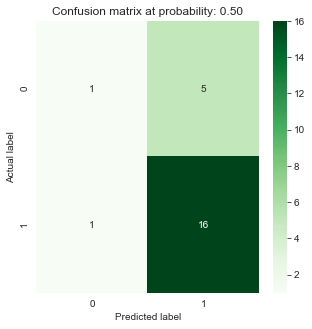

In [56]:
plot_cm(y_val, y_pred_final_mlp)

This is unfortunate. It seems like our model has learned to classify almost all mushrooms as 1, which is not desired.

### Finding best hyper parameters - Tuning Logistic Regression

In [58]:
# choose parameter differences

param_grid = [{'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
               'C': [0.4, 0.5, 1, 2, 3]}]

# fit a new model!

glm_2 = LogisticRegression(random_state = 1, class_weight = 'balanced', max_iter = 1000)
grid_search_glm = GridSearchCV(glm_2, param_grid, cv=cv,
                           scoring= 'f1',
                           return_train_score=True)

# search
grid_search_glm.fit(X_train, y_train);

C:\anaconda_\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\anaconda_\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\anaconda_\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. Th

C:\anaconda_\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\anaconda_\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' wi

C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\a

C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\a

C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\anaconda_\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\a

In [59]:
# see best parameters to maximize f1 score on training set.

print(grid_search_glm.best_params_)

{'C': 0.4, 'penalty': 'none'}


#### Fit with new hyperparameters

In [145]:
# fit final model

glm_final = LogisticRegression(random_state = 1, 
                               class_weight = 'balanced',
                               penalty = 'none',
                               max_iter = 1000)

glm_fit_final = glm_final.fit(X_train, y_train)
y_pred_final = glm_fit_final.predict(X_val)


scores = cross_val_score(glm_fit_final, X_train, y_train, scoring = 'f1', cv = cv)
print('Mean f1: %.3f' % np.mean(scores))

Mean f1: 0.806


We have slightly improved performance. Let's see confusion matrix.

Mushroom detected as inedible (True Negatives):  2
Mushroom incorrectly predicted as edible (False Positives):  4
Mushroom incorrectly predicted as inedible (False Negatives):  6
Mushroom detected as edible (True Positives):  11
Total edible mushrooms:  17


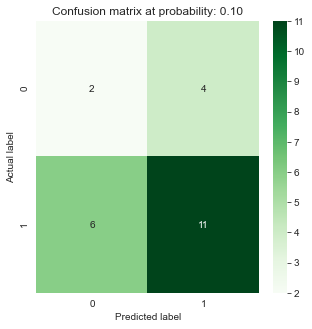

In [206]:
# Since our model outputs probabilities, we can play with the threshold and therefore modify the desired amount of FP.

y_probs_final = glm_fit_final.predict_proba(X_val)
probs_edible_final = y_probs_final[:,1:2]

plot_cm(y_val, probs_edible_final, p = 0.1)

**It seems that the model is not very good, but keep in mind that we want as little FP as possible. Due to the model classifying certain mushrooms as close to 1 (probability of being edible approaches 1, such as 0.999) this is as good as we can get. If we set the probability higher, we reach not much better results.**

### Feature importance - which features best predict toxicity?

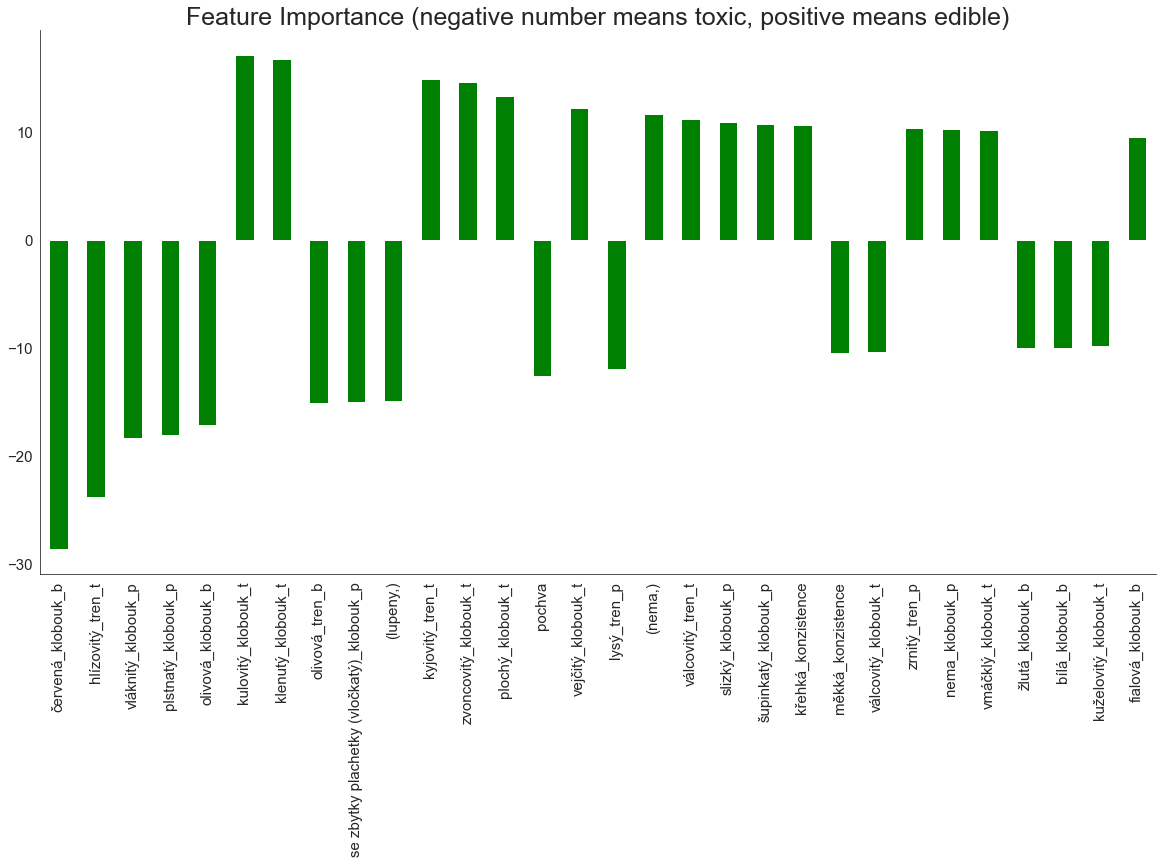

In [147]:
# create data frame of all coefficients, put to dataframe
coef_glm = pd.DataFrame(glm_fit_final.coef_).T.rename(columns = {0: 'Importances'})
cols = pd.DataFrame(features.columns)

# add names of variables
coef_glm['Variables'] = cols

# sort descending, set index
coef_glm = coef_glm.iloc[(-coef_glm['Importances'].abs()).argsort()][:30]

# create plot
axs = coef_glm.plot.bar(y = 'Importances', x = 'Variables', color = 'g', figsize = (20,10), legend = False, fontsize = 15)
sns.despine()
axs.set_xlabel('')
axs.set_title('Feature Importance (negative number means toxic, positive means edible)', fontsize = 25);

### Evaluate logistic regression on final test set

Mushroom detected as inedible (True Negatives):  3
Mushroom incorrectly predicted as edible (False Positives):  4
Mushroom incorrectly predicted as inedible (False Negatives):  3
Mushroom detected as edible (True Positives):  19
Total edible mushrooms:  22
f1: 0.600


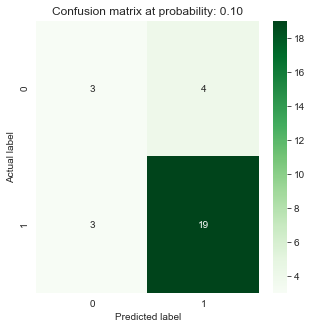

In [207]:
y_probs_final_test = glm_fit_final.predict_proba(X_test)
probs_edible_final_test = y_probs_final_test[:,1:2]

plot_cm(y_test, probs_edible_final_test, p = 0.1)
print('f1: %.3f' % f1_score(y_pred_final, y_val))

Below we can see the 4 misclassified mushrooms. 

It is not so surprising that two "holubinka" were classified as edible, due to the fact that most "holubinka" mushroom _are_ edible and look fairly similar to other edible mushrooms. 

Same goes for "hadovka", which looks like a regular mushroom and may have therefore been classified as edible. 

As for Anýzovník, note that it is the only mushroom that has "rourky" hymenofor out of these 4 - which is usually a sign of edible! Only 4 mushrooms out of 32 that have this hymenofor are inedible.

In [186]:
finalpreds = X_test.copy()

finalpreds['predicted'] = probs_edible_final_test
finalpreds['label'] = y_test

finalpreds[(finalpreds['predicted'].gt(0.25) & finalpreds['label'].eq(0))]

,pochva,prsten,bílá_klobouk_b,fialová_klobouk_b,hnědá_klobouk_b,modrá_klobouk_b,nema_klobouk_b,okrová_klobouk_b,olivová_klobouk_b,oranžová_klobouk_b,...,nahoru ztenčující_tren_t,nema_tren_t,soudkovitý_tren_t,válcovitý_tren_t,"(lupeny,)","(nema,)","(ostny,)","(rourky,)",predicted,label
jmeno,,,,,,,,,,,,,,,,,,,,,
Holubinka smrdutá,0.0,0.0,0,0,1,0,0,0,0,0,...,0,0,0,1,1.0,0.0,0.0,0.0,1.000000,0
Hadovka smrdutá,1.0,0.0,0,0,0,0,0,0,1,0,...,1,0,0,1,0.0,1.0,0.0,0.0,1.000000,0
Anýzovník vonný,0.0,0.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0.0,0.0,0.0,1.0,0.548176,0
Holubinka vrhavka,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,1,1.0,0.0,0.0,0.0,0.999999,0


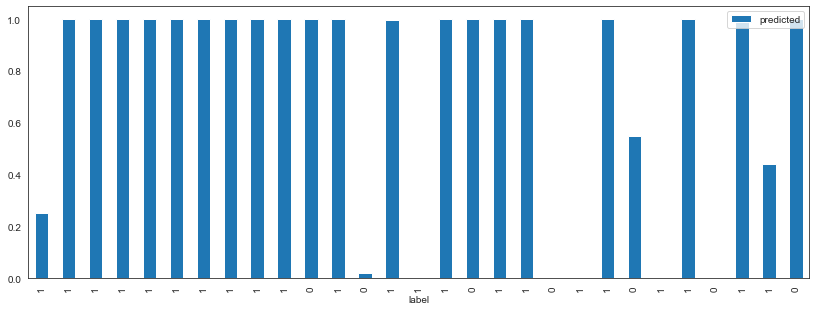

In [197]:
finalpreds.plot.bar(y= 'predicted', x = 'label', figsize = (14, 5))